# 6DoF Pose Estimation with Ultrasound Frames and IMU Data


## 1. Import Libraries


In [1]:
import logging
import math
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms.functional as F
import yaml
from ahrs.filters import Madgwick
from natsort import natsorted
from numpy.linalg import svd
from rich.console import Console
from rich.logging import RichHandler
from rich.progress import Progress
from scipy.interpolate import interp1d
from scipy.ndimage import zoom
from scipy.spatial.transform import Rotation
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

## 2. Configuration


In [2]:
# Initialize the console and logger
console = Console()
logging.basicConfig(level="INFO", handlers=[RichHandler()])
logger = logging.getLogger("rich")


# Load configuration from a YAML file or define directly here
CONFIG_PATH = "configs/default_config.yaml"


def load_config(config_path):
    with open(config_path, "r") as file:
        return yaml.safe_load(file)


config = load_config(CONFIG_PATH)

# Extract values from config
BATCH_SIZE_TRAIN = config["batch_size_train"]
BATCH_SIZE_VAL = config["batch_size_val"]
DEVICE = torch.device(config["device"] if torch.cuda.is_available() else "cpu")
DOWNSAMPLE_FACTOR = config["downsample_factor"]
LEARNING_RATE = config["learning_rate"]
MODEL_SAVE_DIR = config["model_save_dir"]
MODEL_TYPE = config["model_type"]
NUM_EPOCHS = config["num_epochs"]
NUMERIC_COLUMNS = config["numeric_columns"]
PATIENCE = config["patience"]
PLOT_FRAME_STRIDE = config["plot_frame_stride"]
PLOT_SCALE = config["plot_scale"]
PROBE_SPECS = config["probe_specs"]
RECONSTRUCTION_VOXEL_SIZE = config["reconstruction_voxel_size"]
SAMPLING_RATE = config["sampling_rate"]
SCALING_FACTOR_ROTATION = config["scaling_factor_rotation"]
SCALING_FACTOR_TRANSLATION = config["scaling_factor_translation"]
SCAN_DIR = config["scan_dir"]
SEQUENCE_LENGTH = config["sequence_length"]
TEST_SIZE = config["val_split"]

## 3. Dataset Class


In [3]:
class PoseEstimationDatasetDisplacement(Dataset):
    def __init__(
        self,
        df,
        transform=None,
        downsample_factor=DOWNSAMPLE_FACTOR,
        scaling_factor_translation=SCALING_FACTOR_TRANSLATION,
        scaling_factor_rotation=SCALING_FACTOR_ROTATION,
        shuffle=False,
    ):
        self.df = df
        self.transform = transform
        self.downsample_factor = downsample_factor
        self.scaling_factor_translation = scaling_factor_translation
        self.scaling_factor_rotation = scaling_factor_rotation

        # Generate pairs of consecutive frames
        self.pairs = [
            (self.df.iloc[i], self.df.iloc[i + 1]) for i in range(len(self.df) - 1)
        ]

        # Shuffle the pairs if required
        if shuffle:
            np.random.shuffle(self.pairs)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        row1, row2 = self.pairs[idx]

        # Load and process image frames for frames n-1 and n
        frame_n_1 = self.load_and_process_frame(row1["frame"])
        frame_n = self.load_and_process_frame(row2["frame"])
        frames = torch.stack([frame_n_1, frame_n])  # Shape: (2, C, H, W)

        # Extract IMU data (acceleration and Euler angles) for frames n-1 and n
        imu_data_n_1 = self.get_imu_data(row1)
        imu_data_n = self.get_imu_data(row2)
        imu_data = torch.stack([imu_data_n_1, imu_data_n])  # Shape: (2, 6)

        # Calculate the target as the displacement between frames n-1 and n
        delta_translation = self.calculate_translation(row1, row2)
        delta_rotation_euler = self.calculate_rotation_euler(row1, row2)
        target = torch.cat((delta_translation, delta_rotation_euler))  # Shape: (6)

        return frames, imu_data, target

    def load_and_process_frame(self, frame):
        frame = torch.tensor(np.stack(frame)).float().permute(2, 0, 1)  # (C, H, W)
        if self.downsample_factor > 1:
            frame = F.resize(
                frame, [dim // self.downsample_factor for dim in frame.shape[1:]]
            )
        return frame

    def get_imu_data(self, row):
        imu_data = np.array(
            [
                row["imu_acc_x"],
                row["imu_acc_y"],
                row["imu_acc_z"],
                row["imu_orientation_x"],
                row["imu_orientation_y"],
                row["imu_orientation_z"],
            ]
        )

        # Ensure IMU data is correctly shaped
        if imu_data.shape != (6,):
            raise ValueError(
                f"Invalid IMU data shape: expected (6,), got {imu_data.shape}"
            )

        return torch.tensor(imu_data).float()

    def calculate_translation(self, row1, row2):
        return (
            torch.tensor(
                [
                    row2["ot_pos_x"] - row1["ot_pos_x"],
                    row2["ot_pos_y"] - row1["ot_pos_y"],
                    row2["ot_pos_z"] - row1["ot_pos_z"],
                ]
            ).float()
            / self.scaling_factor_translation
        )

    def calculate_rotation_euler(self, row1, row2):
        q1 = Rotation.from_quat(
            [row1["ot_qx"], row1["ot_qy"], row1["ot_qz"], row1["ot_qw"]]
        )
        q2 = Rotation.from_quat(
            [row2["ot_qx"], row2["ot_qy"], row2["ot_qz"], row2["ot_qw"]]
        )
        delta_rotation = q2 * q1.inv()  # Relative rotation from n-1 to n
        return (
            torch.tensor(delta_rotation.as_euler("xyz")).float()
            / self.scaling_factor_rotation
        )

## 4. Utility Functions


In [4]:
def load_data(directory_path):
    directory = Path(directory_path)
    file_paths = natsorted(directory.glob("*.h5"))
    dfs = [pd.read_hdf(file_path) for file_path in file_paths]

    logger.info("Loaded the following files:")
    for file in file_paths:
        console.print(f"[green]{file}[/green]")

    return dfs


def calculate_sampling_rate(df, timestamp_column="timestamp"):
    # Ensure the timestamps are in datetime format (if they are not already)
    df[timestamp_column] = pd.to_datetime(df[timestamp_column])

    # Calculate time differences between consecutive timestamps
    time_deltas = df[timestamp_column].diff().dropna()

    # Convert time deltas to seconds
    time_deltas_in_seconds = time_deltas.dt.total_seconds()

    # Calculate the average sampling rate (in Hz)
    sampling_rate = 1 / time_deltas_in_seconds.mean()

    return sampling_rate


def split_dataset(dfs, val_size=0.2, test_size=0.1):
    num_files = len(dfs)

    # Ensure at least one file is allocated to validation and test sets if there are fewer than 10 files
    num_test_files = max(1, math.ceil(num_files * test_size))
    num_val_files = max(1, math.ceil(num_files * val_size))

    # Split files
    train_dfs, temp_dfs = train_test_split(
        dfs, test_size=num_val_files + num_test_files, shuffle=False
    )
    val_dfs, test_dfs = train_test_split(
        temp_dfs, test_size=num_test_files, shuffle=False
    )

    logger.info(f"Total files: {num_files}")
    logger.info(
        f"Training files: {len(train_dfs)}, Validation files: {len(val_dfs)}, Test files: {len(test_dfs)}"
    )

    train_dataset = PoseEstimationDatasetDisplacement(pd.concat(train_dfs))
    val_dataset = PoseEstimationDatasetDisplacement(pd.concat(val_dfs))
    test_dataset = PoseEstimationDatasetDisplacement(pd.concat(test_dfs))

    return train_dataset, val_dataset, test_dataset


def preprocess_data(df, numeric_columns):
    logger.info("Preprocessing DataFrame...")
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="raise")

    console.print(df.head())
    logger.info(f"Sampling rate: {calculate_sampling_rate(df)} Hz")

    return df


def split_dataset(dfs, val_size=0.2, test_size=0.1):
    num_files = len(dfs)

    # Ensure at least one file is allocated to validation and test sets if there are fewer than 10 files
    num_test_files = max(1, math.ceil(num_files * test_size))
    num_val_files = max(1, math.ceil(num_files * val_size))

    # Split files
    train_dfs, temp_dfs = train_test_split(
        dfs, test_size=num_val_files + num_test_files, shuffle=False
    )
    val_dfs, test_dfs = train_test_split(
        temp_dfs, test_size=num_test_files, shuffle=False
    )

    logger.info(f"Total files: {num_files}")
    logger.info(
        f"Training files: {len(train_dfs)}, Validation files: {len(val_dfs)}, Test files: {len(test_dfs)}"
    )

    train_dataset = PoseEstimationDatasetDisplacement(pd.concat(train_dfs))
    val_dataset = PoseEstimationDatasetDisplacement(pd.concat(val_dfs))
    test_dataset = PoseEstimationDatasetDisplacement(pd.concat(test_dfs))

    return train_dataset, val_dataset, test_dataset


def create_data_loaders(
    train_dataset, val_dataset, test_dataset, batch_size_train, batch_size_val
):
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_val, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size_val, shuffle=False)

    logger.info(
        f"Training samples: {len(train_loader.dataset)}, Validation samples: {len(val_loader.dataset)}, Test samples: {len(test_loader.dataset)}"
    )

    return train_loader, val_loader, test_loader


def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for frames, imu_data, targets in val_loader:
            frames, imu_data, targets = (
                frames.to(DEVICE),
                imu_data.to(DEVICE),
                targets.to(DEVICE),
            )
            outputs = model(frames, imu_data)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    return val_loss / len(val_loader)


def calculate_input_displacements(imu_data, delta_t):
    # Initialize the Madgwick filter
    madgwick = Madgwick()

    # Lists to store orientation (Euler angles) and displacements
    orientations = []
    linear_displacements = []

    # Initialize state variables
    orientation = np.array([1, 0, 0, 0]).astype(np.float64)  # Quaternion (w, x, y, z)
    velocity = np.zeros(3).astype(np.float64)
    position = np.zeros(3).astype(np.float64)

    # Loop through the IMU data sequence
    for i in range(len(imu_data)):
        # Handle cases where imu_data[i] has an extra dimension
        acc = imu_data[i, :3].reshape(-1, 3)[0]  # Extract the first set of 3 elements
        gyro = imu_data[i, 3:6].reshape(-1, 3)[0]  # Extract the first set of 3 elements

        # Ensure gyro and acc are numpy arrays
        gyro = np.array(gyro)
        acc = np.array(acc)

        # Validate the extracted data
        if len(gyro) != 3 or len(acc) != 3:
            raise ValueError(f"Invalid IMU data at index {i}: gyro={gyro}, acc={acc}")

        # Update orientation using Madgwick filter (without magnetometer data)
        orientation = madgwick.updateIMU(q=orientation, gyr=gyro, acc=acc)

        # Convert quaternion to Euler angles for angular displacements
        euler = Rotation.from_quat(orientation).as_euler("xyz")
        orientations.append(euler)

        # Update velocity and position (integrating acceleration to get displacement)
        # Subtract gravity from accelerometer z-axis (assuming stationary start)
        # acc[2] -= 9.81

        # Integrate to get velocity and position (displacement)
        velocity += acc * delta_t
        position += velocity * delta_t

        linear_displacements.append(position.copy())

    # Convert lists to numpy arrays for consistency
    linear_displacements = np.array(linear_displacements)
    angular_displacements = np.array(orientations)

    return linear_displacements, angular_displacements


def plot_displacements(gt_linear, gt_angular, input_linear, input_angular):
    time_steps = np.arange(len(gt_linear))

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # Plot linear displacements
    axes[0, 0].plot(time_steps, gt_linear[:, 0], label="GT X")
    axes[0, 0].plot(time_steps, input_linear[:, 0], label="Input X", linestyle="--")
    axes[0, 0].set_title("Linear Displacement X")
    axes[0, 0].legend()

    axes[0, 1].plot(time_steps, gt_linear[:, 1], label="GT Y")
    axes[0, 1].plot(time_steps, input_linear[:, 1], label="Input Y", linestyle="--")
    axes[0, 1].set_title("Linear Displacement Y")
    axes[0, 1].legend()

    axes[0, 2].plot(time_steps, gt_linear[:, 2], label="GT Z")
    axes[0, 2].plot(time_steps, input_linear[:, 2], label="Input Z", linestyle="--")
    axes[0, 2].set_title("Linear Displacement Z")
    axes[0, 2].legend()

    # Plot angular displacements
    axes[1, 0].plot(time_steps, gt_angular[:, 0], label="GT Roll")
    axes[1, 0].plot(time_steps, input_angular[:, 0], label="Input Roll", linestyle="--")
    axes[1, 0].set_title("Angular Displacement Roll")
    axes[1, 0].legend()

    axes[1, 1].plot(time_steps, gt_angular[:, 1], label="GT Pitch")
    axes[1, 1].plot(
        time_steps, input_angular[:, 1], label="Input Pitch", linestyle="--"
    )
    axes[1, 1].set_title("Angular Displacement Pitch")
    axes[1, 1].legend()

    axes[1, 2].plot(time_steps, gt_angular[:, 2], label="GT Yaw")
    axes[1, 2].plot(time_steps, input_angular[:, 2], label="Input Yaw", linestyle="--")
    axes[1, 2].set_title("Angular Displacement Yaw")
    axes[1, 2].legend()

    plt.tight_layout()
    plt.show()

## 5. Model Definition


In [5]:
class PoseEstimationModelDisplacement(nn.Module):
    def __init__(self, downsample_factor=DOWNSAMPLE_FACTOR, seq_len=2):
        super(PoseEstimationModelDisplacement, self).__init__()

        # Load a pretrained ResNeXt model
        resnext = models.resnext50_32x4d(pretrained=True)

        # Keep the first conv layer unchanged (3 input channels instead of 6)
        resnext.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the final fully connected layer
        self.feature_extractor = nn.Sequential(*list(resnext.children())[:-2])

        # 1D convolution to operate on the temporal axis (sequence dimension)
        self.conv1d = nn.Conv1d(
            in_channels=seq_len,  # Use the sequence length as input channels
            out_channels=1,  # Reduce the sequence to a single temporal feature
            kernel_size=1,  # Kernel size 1 to ensure each frame is independently transformed
        )

        # Define the LSTM for IMU data
        self.lstm = nn.LSTM(input_size=6, hidden_size=64, batch_first=True)

        # Dynamically calculate the size of the ResNeXt output after flattening
        self._initialize_fc()

    def _initialize_fc(self):
        # Create a dummy input to calculate the size of the ResNeXt output dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 333, 219)  # Example input size (1 frame)
            dummy_output = self.feature_extractor(dummy_input)
            num_features_resnext = dummy_output.view(1, -1).size(1)

        # Define the fully connected layer
        self.fc = nn.Sequential(
            nn.Linear(
                num_features_resnext + 64, 256
            ),  # Combine ResNeXt and LSTM output sizes
            nn.ReLU(),
            nn.Linear(256, 6),
        )

    def forward(self, frames, imu_data):
        batch_size, seq_len, C, H, W = frames.size()

        # Reshape frames to (batch_size * seq_len, C, H, W)
        frames = frames.view(batch_size * seq_len, C, H, W)

        # Extract features for each frame independently using ResNeXt
        x = self.feature_extractor(
            frames
        )  # Shape: (batch_size * seq_len, num_features, h, w)

        # Flatten the output from ResNeXt
        x = x.view(
            batch_size, seq_len, -1
        )  # Shape: (batch_size, seq_len, num_features)

        # Apply 1D convolution along the sequence dimension to aggregate temporal features
        x = self.conv1d(x)  # Output shape: (batch_size, 1, num_features)

        # Squeeze the sequence dimension
        x = x.squeeze(1)  # Shape: (batch_size, num_features)

        # Process IMU data using LSTM
        lstm_out, _ = self.lstm(imu_data)  # Output shape: (batch_size, seq_len, 64)
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last time step

        # Combine features from ResNeXt and LSTM
        combined = torch.cat((x, lstm_out), dim=1)

        # Pass the combined features through the fully connected layers
        output = self.fc(combined)
        return output

## 6. Training Function


In [6]:
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for frames, imu_data, targets in val_loader:
            frames, imu_data, targets = (
                frames.to(DEVICE),
                imu_data.to(DEVICE),
                targets.to(DEVICE),
            )
            outputs = model(frames, imu_data)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    return val_loss / len(val_loader)


def early_stopping(
    model, val_loss, best_val_loss, best_model_weights, epochs_no_improve, patience
):
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = model.state_dict().copy()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    return best_val_loss, best_model_weights, epochs_no_improve

In [7]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
):
    best_val_loss = float("inf")
    best_model_weights = None
    epochs_no_improve = 0

    with Progress() as progress:
        epoch_task = progress.add_task("Training", total=num_epochs)

        for epoch in range(num_epochs):
            model.train()
            train_loss = 0.0

            # Adding task for data loading within the same progress bar
            batch_task = progress.add_task(
                f"Epoch {epoch+1}/{num_epochs} Batches", total=len(train_loader)
            )

            for frames, imu_data, targets in train_loader:
                frames, imu_data, targets = (
                    frames.to(DEVICE),
                    imu_data.to(DEVICE),
                    targets.to(DEVICE),
                )
                optimizer.zero_grad()

                outputs = model(frames, imu_data)
                loss = criterion(outputs, targets)

                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                progress.advance(batch_task)

            val_loss = validate_model(model, val_loader, criterion)
            scheduler.step(val_loss)

            progress.update(epoch_task, advance=1)

            logger.info(
                f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}"
            )

            best_val_loss, best_model_weights, epochs_no_improve = early_stopping(
                model,
                val_loss,
                best_val_loss,
                best_model_weights,
                epochs_no_improve,
                patience,
            )
            if epochs_no_improve >= patience:
                logger.info("Early stopping triggered")
                break

    model.load_state_dict(best_model_weights)
    return model

## 7. Evaluation Function


In [8]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for frames, imu_data, targets in data_loader:
            frames, imu_data, targets = (
                frames.to(DEVICE),
                imu_data.to(DEVICE),
                targets.to(DEVICE),
            )
            outputs = model(frames, imu_data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    avg_loss = total_loss / len(data_loader)
    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)

    return avg_loss, all_predictions, all_targets

## 8. Visualization Function


In [9]:
def plot_position_orientation_errors(predictions, targets, config):
    fig, axes = plt.subplots(2, 6, figsize=(24, 12))

    pos_titles = ["Position X", "Position Y", "Position Z"]
    orient_titles = ["Orientation X", "Orientation Y", "Orientation Z"]

    for i in range(3):
        plot_ground_truth_vs_predicted(
            axes[0, i], targets[:, i], predictions[:, i], pos_titles[i], "mm"
        )
        plot_error(
            axes[0, i + 3],
            predictions[:, i],
            targets[:, i],
            f"{pos_titles[i]} Error",
            "mm",
        )

    for i in range(3):
        plot_ground_truth_vs_predicted(
            axes[1, i],
            targets[:, i + 3],
            predictions[:, i + 3],
            orient_titles[i],
            "radians",
        )
        plot_error(
            axes[1, i + 3],
            predictions[:, i + 3],
            targets[:, i + 3],
            f"{orient_titles[i]} Error",
            "radians",
        )

    plt.tight_layout()
    plt.show()


def plot_ground_truth_vs_predicted(ax, ground_truth, predicted, title, ylabel):
    ax.plot(ground_truth, label="Ground Truth", color="b")
    ax.plot(predicted, label="Predicted", color="r", linestyle="--")
    ax.set_title(f"GT vs Predicted {title}")
    ax.set_xlabel("Frame Index")
    ax.set_ylabel(f"{title} ({ylabel})")
    ax.legend()
    ax.grid(True)


def plot_error(ax, predicted, ground_truth, title, ylabel):
    error = predicted - ground_truth
    ax.plot(error, label="Error", color="g")
    ax.set_title(title)
    ax.set_xlabel("Frame Index")
    ax.set_ylabel(f"{ylabel}")
    ax.grid(True)

## 9. Volume Reconstruction and Frame Center Plotting Functions


In [70]:
def reconstruct_ground_truth_volume(
    df, probe_specs, voxel_size=RECONSTRUCTION_VOXEL_SIZE
):
    frames = df["frame"].values
    positions = df[["ot_pos_x", "ot_pos_y", "ot_pos_z"]].values
    orientations = df[["ot_qw", "ot_qx", "ot_qy", "ot_qz"]].values

    depth = probe_specs["depth"]
    width = probe_specs["width"]
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]

    axial_scale = depth / 1000
    lateral_scale = width / 657

    rotations = Rotation.from_quat(orientations[:, [1, 2, 3, 0]])

    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )

    transform_matrix = np.array(
        [
            [0, 0, -1],
            [1, 0, 0],
            [0, -1, 0],
        ]
    )

    frame_corners = frame_corners @ transform_matrix.T
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = (
        np.einsum("ijk,lk->ilj", rotations.as_matrix(), frame_corners)
        + positions[:, np.newaxis, :]
    )
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    x, y = np.meshgrid(np.arange(657) * lateral_scale, np.arange(1000) * axial_scale)
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    frame_centers = []
    frame_orientations = []

    print("Reconstructing ground truth volume...")
    for i, (frame, position, orientation) in enumerate(
        tqdm(zip(frames, positions, orientations), total=len(frames))
    ):
        frame = np.mean(frame, axis=-1).astype(np.float32)

        rotation = Rotation.from_quat(orientation[[1, 2, 3, 0]]).as_matrix()
        world_coords = np.einsum("ij,klj->kli", rotation, frame_coords) + position

        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

        frame_center = np.mean(all_corners[i], axis=0)
        frame_centers.append(frame_center)
        frame_orientations.append(orientation[[1, 2, 3, 0]])

    mask = counts > 0
    volume[mask] /= counts[mask]

    return (
        volume,
        min_corner,
        voxel_size,
        np.array(frame_centers),
        np.array(frame_orientations),
    )


def plot_frame_center_trajectories_with_error(
    gt_centers,
    gt_orientations,
    pred_centers,
    pred_orientations,
    frame_stride=PLOT_FRAME_STRIDE,
    scale=PLOT_SCALE,
):
    fig = plt.figure(figsize=(20, 6))

    ax1 = fig.add_subplot(131, projection="3d")
    plot_trajectory(
        ax1, gt_centers, gt_orientations, frame_stride, scale, "Ground Truth", "blue"
    )

    ax2 = fig.add_subplot(132, projection="3d")
    plot_trajectory(
        ax2, pred_centers, pred_orientations, frame_stride, scale, "Predicted", "red"
    )

    ax3 = fig.add_subplot(133)
    plot_trajectory_error(ax3, gt_centers, pred_centers)

    plt.tight_layout()
    plt.show()


def plot_trajectory(ax, centers, orientations, frame_stride, scale, title, color):
    ax.plot(
        centers[:, 0], centers[:, 1], centers[:, 2], label="Trajectory", color=color
    )

    for i in range(0, len(centers), frame_stride):
        pos = centers[i]

        # Assuming the orientations are Euler angles, convert them to quaternions
        if orientations.shape[1] == 3:
            quat = Rotation.from_euler("xyz", orientations[i]).as_quat()
        else:
            quat = orientations[i]

        rot_matrix = Rotation.from_quat(quat).as_matrix()

        axes = np.array([[scale, 0, 0], [0, scale, 0], [0, 0, scale]])
        transformed_axes = rot_matrix @ axes.T + pos[:, np.newaxis]

        colors = ["r", "g", "b"]
        labels = ["X", "Y", "Z"]
        for j, (axis_color, label) in enumerate(zip(colors, labels)):
            ax.quiver(
                pos[0],
                pos[1],
                pos[2],
                transformed_axes[0, j] - pos[0],
                transformed_axes[1, j] - pos[1],
                transformed_axes[2, j] - pos[2],
                color=axis_color,
                label=f"{label} axis" if i == 0 else "",
            )

    ax.set_xlabel("X Position (mm)")
    ax.set_ylabel("Y Position (mm)")
    ax.set_zlabel("Z Position (mm)")
    ax.set_title(f"{title} Frame Center Trajectory")
    ax.legend()


def interpolate_trajectory(centers, num_points=100):
    x = np.arange(len(centers))
    interp_func = interp1d(x, centers, axis=0, kind="linear")
    x_new = np.linspace(0, len(centers) - 1, num=num_points)
    return interp_func(x_new)


def plot_trajectory_error(ax, gt_centers, pred_centers):
    # Ensure both arrays have the same length
    min_length = min(len(gt_centers), len(pred_centers))

    # Truncate both to the minimum length
    gt_centers_truncated = gt_centers[:-min_length]
    pred_centers_truncated = pred_centers[:-min_length]

    # Calculate error
    error = np.linalg.norm(pred_centers_truncated - gt_centers_truncated, axis=1)

    # Plot error
    ax.plot(error, color="green")
    ax.set_title("Frame Center Position Error Over Time")
    ax.set_xlabel("Frame Index")
    ax.set_ylabel("Position Error (mm)")
    ax.grid(True)

## 10. Predicted Volume Reconstruction


In [59]:
def reconstruct_predicted_volume_displacement(
    frames,
    predicted_displacements,
    probe_specs,
    voxel_size=RECONSTRUCTION_VOXEL_SIZE,
    scaling_factor_translation=SCALING_FACTOR_TRANSLATION,
    scaling_factor_rotation=SCALING_FACTOR_ROTATION,
    initial_pose=None,
    ignore_orientation=False,
    rotation_axes=None,
):
    if initial_pose is None:
        current_position = np.zeros(3)
        current_rotation = np.eye(3)
    else:
        current_position, current_rotation = initial_pose

    depth = probe_specs["depth"]
    width = probe_specs["width"]
    marker_to_probe_bottom = probe_specs["marker_to_probe_bottom"]

    axial_scale = depth / frames.shape[1]
    lateral_scale = width / frames.shape[2]

    frame_corners = np.array(
        [[0, 0, 0], [width, 0, 0], [0, depth, 0], [width, depth, 0]]
    )
    transform_matrix = np.array(
        [
            [0, 0, -1],
            [1, 0, 0],
            [0, -1, 0],
        ]
    )
    frame_corners = frame_corners @ transform_matrix.T
    frame_corners[:, 2] += marker_to_probe_bottom

    all_corners = []
    positions = []

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    print("Reconstructing predicted volume...")
    for i, (frame, displacement) in enumerate(
        tqdm(zip(frames, predicted_displacements), total=len(frames))
    ):
        translation = displacement[:3] * scaling_factor_translation
        euler_angles = displacement[3:] * scaling_factor_rotation

        # Convert Euler angles to a quaternion
        quaternion = Rotation.from_euler("xyz", euler_angles).as_quat()

        rotation_matrix = Rotation.from_quat(quaternion).as_matrix()

        current_position += current_rotation @ translation
        current_rotation = current_rotation @ rotation_matrix

        corners_world = (
            np.einsum("ij,kj->ki", current_rotation, frame_corners) + current_position
        )
        all_corners.append(corners_world)

        positions.append(current_position.copy())

        for corner in corners_world:
            ax.scatter(
                corner[0],
                corner[1],
                corner[2],
                color="red",
                marker=".",
                label="Frame Corner" if i == 0 else "",
            )

    for j, corners in enumerate([all_corners[0], all_corners[-1]]):
        label = "Initial Frame" if j == 0 else "Final Frame"
        color = "blue" if j == 0 else "green"

        ax.plot(
            [corners[0][0], corners[1][0]],
            [corners[0][1], corners[1][1]],
            [corners[0][2], corners[1][2]],
            color=color,
            label=label if j == 0 else "",
        )
        ax.plot(
            [corners[1][0], corners[3][0]],
            [corners[1][1], corners[3][1]],
            [corners[1][2], corners[3][2]],
            color=color,
        )
        ax.plot(
            [corners[3][0], corners[2][0]],
            [corners[3][1], corners[2][1]],
            [corners[3][2], corners[2][2]],
            color=color,
        )
        ax.plot(
            [corners[2][0], corners[0][0]],
            [corners[2][1], corners[0][1]],
            [corners[2][2], corners[0][2]],
            color=color,
        )

    all_corners = np.array(all_corners)
    min_corner = np.min(all_corners.reshape(-1, 3), axis=0)
    max_corner = np.max(all_corners.reshape(-1, 3), axis=0)

    volume_shape = np.ceil((max_corner - min_corner) / voxel_size).astype(int) + 1
    volume = np.zeros(volume_shape, dtype=np.float32)
    counts = np.zeros(volume_shape, dtype=np.int32)

    x, y = np.meshgrid(
        np.arange(frames.shape[2]) * lateral_scale,
        np.arange(frames.shape[1]) * axial_scale,
    )
    frame_coords = np.stack((x, y, np.zeros_like(x)), axis=-1)
    frame_coords = frame_coords @ transform_matrix.T
    frame_coords[:, :, 2] += marker_to_probe_bottom

    for i, frame in enumerate(tqdm(frames, total=len(frames))):
        if frame.ndim == 3:
            frame = np.mean(frame, axis=-1).astype(np.float32)

        world_coords = (
            np.einsum("ij,klj->kli", current_rotation, frame_coords) + current_position
        )

        voxel_coords = np.round((world_coords - min_corner) / voxel_size).astype(int)

        mask = np.all((voxel_coords >= 0) & (voxel_coords < volume_shape), axis=2)
        valid_voxels = voxel_coords[mask]
        valid_intensities = frame[mask]

        np.add.at(volume, tuple(valid_voxels.T), valid_intensities)
        np.add.at(counts, tuple(valid_voxels.T), 1)

    mask = counts > 0
    volume[mask] /= counts[mask]

    ax.set_xlabel("X Position (mm)")
    ax.set_ylabel("Y Position (mm)")
    ax.set_zlabel("Z Position (mm)")
    ax.set_title("Probe Position and Frame Corners Over Time")
    ax.legend()
    plt.show()

    return volume, min_corner, voxel_size

## 11. Inference and Prediction


In [12]:
def inference_and_prediction(val_loader, model):
    all_frames = []
    all_predictions = []

    with torch.no_grad():
        for frames, imu_data, _ in val_loader:
            frames = frames.to(DEVICE)
            imu_data = imu_data.to(DEVICE)
            outputs = model(frames, imu_data)  # Predicted displacements

            all_frames.append(frames.cpu().numpy())
            all_predictions.append(outputs.cpu().numpy())

    all_frames = np.concatenate(all_frames, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    return all_frames, all_predictions

## 12. Main Execution


In [13]:
# Load and preprocess data
dfs = load_data(SCAN_DIR)
dfs = [preprocess_data(df, NUMERIC_COLUMNS) for df in dfs]

[09/06/24 11:38:21] INFO     INFO:rich:Loaded the following files:                                  ]8;id=230536;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=620025;file:///tmp/ipykernel_1816552/3322855690.py#6\6]8;;\

/home/varun/xia_lab/repos/ABUSFusion/scans/wrist/wrist1_na_2608.h5

/home/varun/xia_lab/repos/ABUSFusion/scans/wrist/wrist1_vs_2608.h5

/home/varun/xia_lab/repos/ABUSFusion/scans/wrist/wrist1_yx_2608.h5

/home/varun/xia_lab/repos/ABUSFusion/scans/wrist/wrist2_na_2608.h5

/home/varun/xia_lab/repos/ABUSFusion/scans/wrist/wrist2_yx_2608.h5

                    INFO     INFO:rich:Preprocessing DataFrame...                                  ]8;id=610649;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=996419;file:///tmp/ipykernel_1816552/3322855690.py#57\57]8;;\

timestamp  \
0 2024-08-26 14:52:35.775281   
1 2024-08-26 14:52:35.875281   
2 2024-08-26 14:52:35.975281   
3 2024-08-26 14:52:36.075281   
4 2024-08-26 14:52:36.175281   

                                               frame  imu_acc_x  imu_acc_y  \
0  [[[47, 50, 50], [63, 66, 66], [72, 75, 75], [8...   0.001531  -0.037256   
1  [[[47, 50, 50], [63, 66, 66], [72, 75, 75], [8...   0.001531  -0.037256   
2  [[[47, 50, 50], [63, 66, 66], [72, 75, 75], [8...   0.001531  -0.037256   
3  [[[47, 50, 50], [63, 66, 66], [72, 75, 75], [8...   0.001531  -0.037256   
4  [[[48, 51, 51], [64, 67, 67], [73, 76, 76], [9...   0.001531  -0.037256   

   imu_acc_z  imu_orientation_x  imu_orientation_y  imu_orientation_z  \
0   0.142704           0.001065           0.020228          -0.009582   
1   0.142704           0.001065           0.020228          -0.009582   
2   0.142704           0.001065           0.020228          -0.009582   
3   0.142704           0.001065           0.020228          -0.009582   
4   0.142704           0.001065           0.020228          -0.009582   

    ot_pos_x  ot_pos_y    ot_pos_z     ot_qw     ot_qx     ot_qy    ot_qz  
0  47.829292 -2.076262 -956.889526  0.274516  0.646665 -0.158583  0.69377  
1  47.829292 -2.076262 -956.889526  0.274516  0.646665 -0.158583  0.69377  
2  47.829292 -2.076262 -956.889526  0.274516  0.646665 -0.158583  0.69377  
3  47.829292 -2.076262 -956.889526  0.274516  0.646665 -0.158583  0.69377  
4  47.829292 -2.076262 -956.889526  0.274516  0.646665 -0.158583  0.69377

[09/06/24 11:38:22] INFO     INFO:rich:Sampling rate: 10.0 Hz                                      ]8;id=272992;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=978224;file:///tmp/ipykernel_1816552/3322855690.py#61\61]8;;\

                    INFO     INFO:rich:Preprocessing DataFrame...                                  ]8;id=741972;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=853780;file:///tmp/ipykernel_1816552/3322855690.py#57\57]8;;\

timestamp  \
0 2024-08-26 16:14:44.582707   
1 2024-08-26 16:14:44.682707   
2 2024-08-26 16:14:44.782707   
3 2024-08-26 16:14:44.882707   
4 2024-08-26 16:14:44.982707   

                                               frame  imu_acc_x  imu_acc_y  \
0  [[[47, 50, 50], [54, 57, 57], [69, 72, 72], [7...  -0.020659  -0.012293   
1  [[[49, 52, 52], [63, 66, 66], [75, 78, 78], [8...  -0.020659  -0.012293   
2  [[[49, 52, 52], [63, 66, 66], [75, 78, 78], [8...  -0.020659  -0.012293   
3  [[[49, 52, 52], [63, 66, 66], [75, 78, 78], [8...  -0.020659  -0.012293   
4  [[[36, 39, 39], [52, 55, 55], [61, 64, 64], [7...  -0.020659  -0.012293   

   imu_acc_z  imu_orientation_x  imu_orientation_y  imu_orientation_z  \
0   0.046763           0.014905          -0.080911          -0.039391   
1   0.046763           0.014905          -0.080911          -0.039391   
2   0.046763           0.014905          -0.080911          -0.039391   
3   0.046763           0.014905          -0.080911          -0.039391   
4   0.046763           0.014905          -0.080911          -0.039391   

   ot_pos_x   ot_pos_y    ot_pos_z     ot_qw     ot_qx     ot_qy     ot_qz  
0  62.52491  12.569681 -910.697815  0.268198  0.672982 -0.238632  0.646699  
1  62.52491  12.569681 -910.697815  0.268198  0.672982 -0.238632  0.646699  
2  62.52491  12.569681 -910.697815  0.268198  0.672982 -0.238632  0.646699  
3  62.52491  12.569681 -910.697815  0.268198  0.672982 -0.238632  0.646699  
4  62.52491  12.569681 -910.697815  0.268198  0.672982 -0.238632  0.646699

[09/06/24 11:38:24] INFO     INFO:rich:Sampling rate: 10.0 Hz                                      ]8;id=250657;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=369577;file:///tmp/ipykernel_1816552/3322855690.py#61\61]8;;\

                    INFO     INFO:rich:Preprocessing DataFrame...                                  ]8;id=58198;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=169610;file:///tmp/ipykernel_1816552/3322855690.py#57\57]8;;\

timestamp  \
0 2024-08-26 15:02:44.899744   
1 2024-08-26 15:02:44.999744   
2 2024-08-26 15:02:45.099744   
3 2024-08-26 15:02:45.199744   
4 2024-08-26 15:02:45.299744   

                                               frame  imu_acc_x  imu_acc_y  \
0  [[[35, 38, 38], [42, 45, 45], [54, 57, 57], [5...   -0.00338   0.001333   
1  [[[35, 38, 38], [42, 45, 45], [54, 57, 57], [5...   -0.00338   0.001333   
2  [[[35, 38, 38], [42, 45, 45], [54, 57, 57], [5...   -0.00338   0.001333   
3  [[[35, 38, 38], [42, 45, 45], [54, 57, 57], [5...   -0.00338   0.001333   
4  [[[35, 38, 38], [42, 45, 45], [54, 57, 57], [5...   -0.00338   0.001333   

   imu_acc_z  imu_orientation_x  imu_orientation_y  imu_orientation_z  \
0   0.061658          -0.002129          -0.020228          -0.003194   
1   0.061658          -0.002129          -0.020228          -0.003194   
2   0.061658          -0.002129          -0.020228          -0.003194   
3   0.061658          -0.002129          -0.020228          -0.003194   
4   0.061658          -0.002129          -0.020228          -0.003194   

    ot_pos_x   ot_pos_y   ot_pos_z     ot_qw     ot_qx    ot_qy     ot_qz  
0  71.562347 -15.736689 -908.01886  0.316188  0.701354 -0.23605  0.593639  
1  71.562347 -15.736689 -908.01886  0.316188  0.701354 -0.23605  0.593639  
2  71.562347 -15.736689 -908.01886  0.316188  0.701354 -0.23605  0.593639  
3  71.562347 -15.736689 -908.01886  0.316188  0.701354 -0.23605  0.593639  
4  71.562347 -15.736689 -908.01886  0.316188  0.701354 -0.23605  0.593639

[09/06/24 11:38:25] INFO     INFO:rich:Sampling rate: 10.0 Hz                                      ]8;id=413085;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=757618;file:///tmp/ipykernel_1816552/3322855690.py#61\61]8;;\

                    INFO     INFO:rich:Preprocessing DataFrame...                                  ]8;id=652734;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=226403;file:///tmp/ipykernel_1816552/3322855690.py#57\57]8;;\

timestamp  \
0 2024-08-26 14:57:56.974394   
1 2024-08-26 14:57:57.074394   
2 2024-08-26 14:57:57.174394   
3 2024-08-26 14:57:57.274394   
4 2024-08-26 14:57:57.374394   

                                               frame  imu_acc_x  imu_acc_y  \
0  [[[63, 66, 66], [82, 85, 85], [95, 98, 98], [1...   0.002471  -0.014853   
1  [[[64, 67, 67], [83, 86, 86], [97, 100, 100], ...   0.002471  -0.014853   
2  [[[63, 66, 66], [82, 85, 85], [95, 98, 98], [1...   0.002471  -0.014853   
3  [[[63, 66, 66], [82, 85, 85], [95, 98, 98], [1...   0.002471  -0.014853   
4  [[[63, 66, 66], [82, 85, 85], [95, 98, 98], [1...   0.002471  -0.014853   

   imu_acc_z  imu_orientation_x  imu_orientation_y  imu_orientation_z  \
0   0.106075          -0.044714           0.034068           0.002129   
1   0.106075          -0.044714           0.034068           0.002129   
2   0.106075          -0.044714           0.034068           0.002129   
3   0.106075          -0.044714           0.034068           0.002129   
4   0.106075          -0.044714           0.034068           0.002129   

    ot_pos_x  ot_pos_y    ot_pos_z     ot_qw     ot_qx     ot_qy     ot_qz  
0  40.435787 -3.075523 -940.780212  0.230672  0.606911 -0.181225  0.738652  
1  40.435787 -3.075523 -940.780212  0.230672  0.606911 -0.181225  0.738652  
2  40.435787 -3.075523 -940.780212  0.230672  0.606911 -0.181225  0.738652  
3  40.435787 -3.075523 -940.780212  0.230672  0.606911 -0.181225  0.738652  
4  40.435787 -3.075523 -940.780212  0.230672  0.606911 -0.181225  0.738652

[09/06/24 11:38:27] INFO     INFO:rich:Sampling rate: 10.0 Hz                                      ]8;id=700299;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=747692;file:///tmp/ipykernel_1816552/3322855690.py#61\61]8;;\

                    INFO     INFO:rich:Preprocessing DataFrame...                                  ]8;id=124382;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=58161;file:///tmp/ipykernel_1816552/3322855690.py#57\57]8;;\

timestamp  \
0 2024-08-26 15:05:39.638751   
1 2024-08-26 15:05:39.738751   
2 2024-08-26 15:05:39.838751   
3 2024-08-26 15:05:39.938751   
4 2024-08-26 15:05:40.038751   

                                               frame  imu_acc_x  imu_acc_y  \
0  [[[30, 33, 33], [44, 47, 47], [54, 57, 57], [6...   0.008532    -0.0076   
1  [[[34, 37, 37], [47, 50, 50], [56, 59, 59], [6...   0.008532    -0.0076   
2  [[[34, 37, 37], [47, 50, 50], [56, 59, 59], [6...   0.008532    -0.0076   
3  [[[34, 37, 37], [47, 50, 50], [56, 59, 59], [6...   0.008532    -0.0076   
4  [[[35, 38, 38], [48, 51, 51], [58, 61, 61], [6...   0.008532    -0.0076   

   imu_acc_z  imu_orientation_x  imu_orientation_y  imu_orientation_z  \
0    0.02942           0.028745           0.018099          -0.044714   
1    0.02942           0.028745           0.018099          -0.044714   
2    0.02942           0.028745           0.018099          -0.044714   
3    0.02942           0.028745           0.018099          -0.044714   
4    0.02942           0.028745           0.018099          -0.044714   

    ot_pos_x   ot_pos_y    ot_pos_z     ot_qw     ot_qx     ot_qy     ot_qz  
0  72.089951 -15.260805 -875.313965  0.349906  0.679817 -0.226727  0.603332  
1  72.089951 -15.260805 -875.313965  0.349906  0.679817 -0.226727  0.603332  
2  72.089951 -15.260805 -875.313965  0.349906  0.679817 -0.226727  0.603332  
3  72.089951 -15.260805 -875.313965  0.349906  0.679817 -0.226727  0.603332  
4  72.089951 -15.260805 -875.313965  0.349906  0.679817 -0.226727  0.603332

[09/06/24 11:38:29] INFO     INFO:rich:Sampling rate: 10.0 Hz                                      ]8;id=95091;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=129929;file:///tmp/ipykernel_1816552/3322855690.py#61\61]8;;\

In [14]:
# Split the data into training, validation, and test sets
train_dataset, val_dataset, test_dataset = split_dataset(
    dfs, val_size=TEST_SIZE, test_size=0.1
)

                    INFO     INFO:rich:Total files: 5                                              ]8;id=590612;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=104265;file:///tmp/ipykernel_1816552/3322855690.py#81\81]8;;\

                    INFO     INFO:rich:Training files: 3, Validation files: 1, Test files: 1       ]8;id=512992;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=564981;file:///tmp/ipykernel_1816552/3322855690.py#82\82]8;;\

In [15]:
# Initialize lists to store results for all samples
all_target_displacements = []
all_target_angular_displacements = []
all_imu_displacements = []
all_imu_angular_displacements = []

# Iterate over the entire dataset
for i in range(len(val_dataset)):
    frames, imu_data, target = val_dataset[i]  # Get a single sample

    imu_data = imu_data.numpy()  # Shape: (2, 6) for two timesteps
    target = target.numpy()  # Shape: (6)

    # Initialize variables for displacement and velocity
    velocity = np.zeros(3)
    position = np.zeros(3)
    delta_t = 1 / float(SAMPLING_RATE)  # Adjust delta_t as per your sampling rate

    # Loop through the sequence length (2 timesteps)
    for j in range(imu_data.shape[0]):
        acc = imu_data[j, :3]  # First three elements are acceleration (X, Y, Z)
        # acc[2] -= 9.81  # Subtract gravity from the Z-axis (assuming stationary start)

        # Integrate acceleration to get velocity
        velocity += acc * delta_t

        # Integrate velocity to get displacement
        position += velocity * delta_t

    # The final IMU-estimated displacement
    imu_displacement = position  # Shape: (3)
    imu_angular_displacement = imu_data[-1, 3:]  # Angular displacement from IMU

    # Extract the target displacements and angular displacements
    target_displacement = target[:3]  # Target displacement
    target_angular_displacement = target[3:]  # Target angular displacement

    # Store results
    all_target_displacements.append(target_displacement)
    all_target_angular_displacements.append(target_angular_displacement)
    all_imu_displacements.append(imu_displacement)
    all_imu_angular_displacements.append(imu_angular_displacement)

# Convert lists to numpy arrays for easier plotting
all_target_displacements = np.array(all_target_displacements)
all_target_angular_displacements = np.array(all_target_angular_displacements)
all_imu_displacements = np.array(all_imu_displacements)
all_imu_angular_displacements = np.array(all_imu_angular_displacements)

# Calculate errors
displacement_errors = all_imu_displacements - all_target_displacements
angular_displacement_errors = (
    all_imu_angular_displacements - all_target_angular_displacements
)

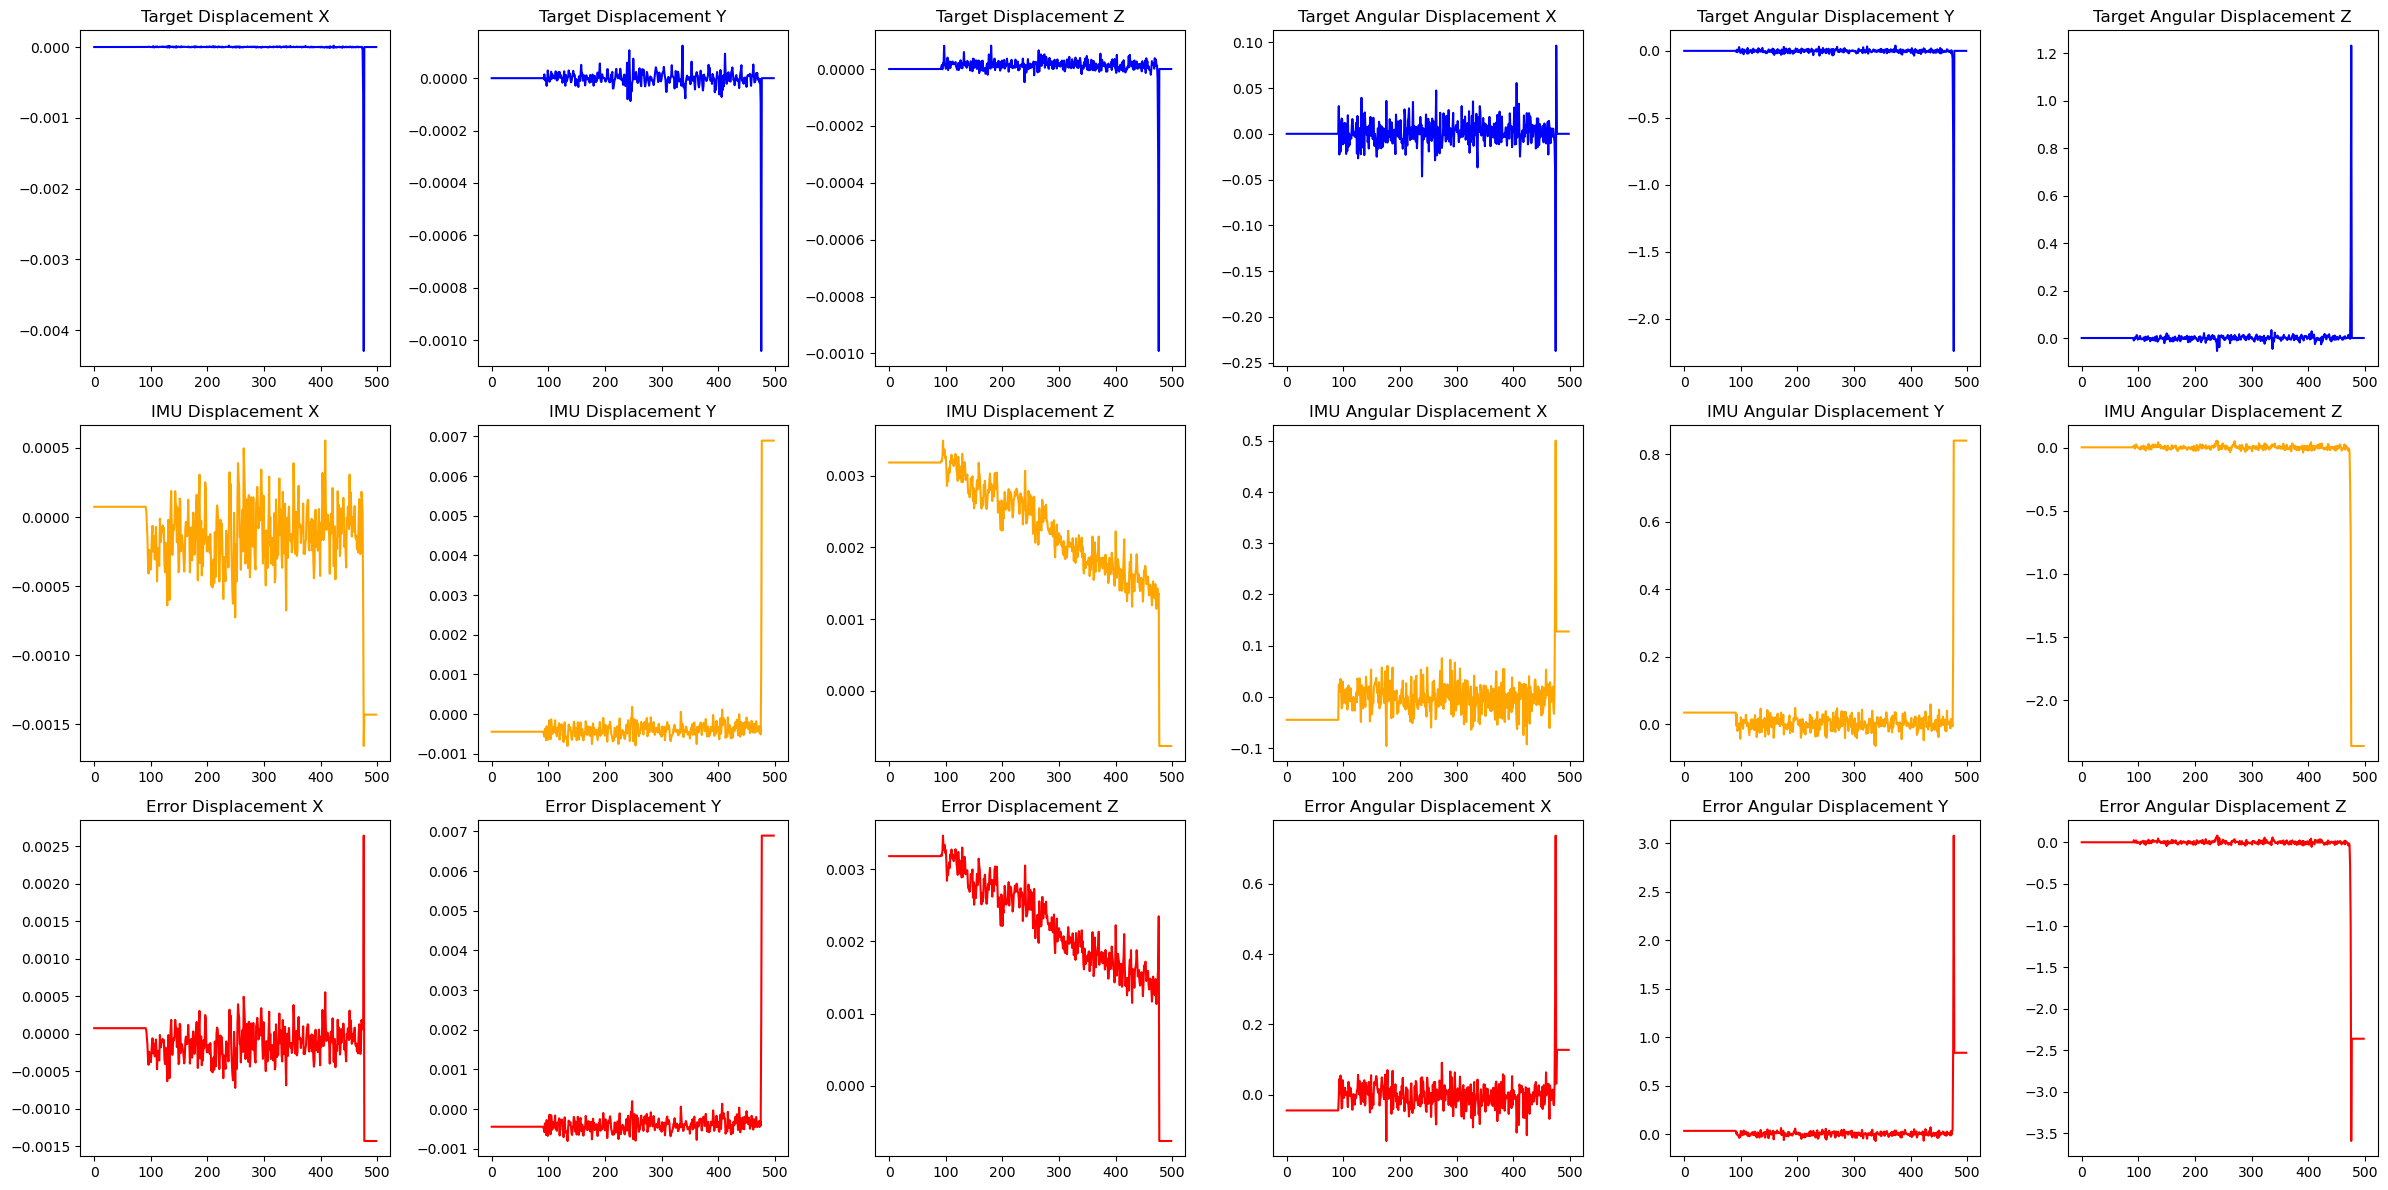

In [16]:
# Plotting in a 3x6 grid
fig, axes = plt.subplots(3, 6, figsize=(24, 12))

# Row 1: Target data (Displacement X, Y, Z, and Angular Displacement X, Y, Z)
axes[0, 0].plot(all_target_displacements[:, 0], color="blue")
axes[0, 0].set_title("Target Displacement X")
axes[0, 1].plot(all_target_displacements[:, 1], color="blue")
axes[0, 1].set_title("Target Displacement Y")
axes[0, 2].plot(all_target_displacements[:, 2], color="blue")
axes[0, 2].set_title("Target Displacement Z")
axes[0, 3].plot(all_target_angular_displacements[:, 0], color="blue")
axes[0, 3].set_title("Target Angular Displacement X")
axes[0, 4].plot(all_target_angular_displacements[:, 1], color="blue")
axes[0, 4].set_title("Target Angular Displacement Y")
axes[0, 5].plot(all_target_angular_displacements[:, 2], color="blue")
axes[0, 5].set_title("Target Angular Displacement Z")

# Row 2: IMU data (Displacement X, Y, Z, and Angular Displacement X, Y, Z)
axes[1, 0].plot(all_imu_displacements[:, 0], color="orange")
axes[1, 0].set_title("IMU Displacement X")
axes[1, 1].plot(all_imu_displacements[:, 1], color="orange")
axes[1, 1].set_title("IMU Displacement Y")
axes[1, 2].plot(all_imu_displacements[:, 2], color="orange")
axes[1, 2].set_title("IMU Displacement Z")
axes[1, 3].plot(all_imu_angular_displacements[:, 0], color="orange")
axes[1, 3].set_title("IMU Angular Displacement X")
axes[1, 4].plot(all_imu_angular_displacements[:, 1], color="orange")
axes[1, 4].set_title("IMU Angular Displacement Y")
axes[1, 5].plot(all_imu_angular_displacements[:, 2], color="orange")
axes[1, 5].set_title("IMU Angular Displacement Z")

# Row 3: Error between target and IMU estimates
axes[2, 0].plot(displacement_errors[:, 0], color="red")
axes[2, 0].set_title("Error Displacement X")
axes[2, 1].plot(displacement_errors[:, 1], color="red")
axes[2, 1].set_title("Error Displacement Y")
axes[2, 2].plot(displacement_errors[:, 2], color="red")
axes[2, 2].set_title("Error Displacement Z")
axes[2, 3].plot(angular_displacement_errors[:, 0], color="red")
axes[2, 3].set_title("Error Angular Displacement X")
axes[2, 4].plot(angular_displacement_errors[:, 1], color="red")
axes[2, 4].set_title("Error Angular Displacement Y")
axes[2, 5].plot(angular_displacement_errors[:, 2], color="red")
axes[2, 5].set_title("Error Angular Displacement Z")

# Final adjustments and show plot
plt.tight_layout()
plt.show()

In [17]:
# Correlation analysis
ot_data = np.hstack((all_target_displacements, all_target_angular_displacements))
imu_data = np.hstack((all_imu_displacements, all_imu_angular_displacements))

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(ot_data.T, imu_data.T)

# Perform PCA on concatenated OT and IMU data
pca = PCA(n_components=6)
pca.fit(np.hstack((all_target_displacements, all_imu_displacements)))

# Print the principal components
print("Principal Components:")
print(pca.components_)

# Singular Value Decomposition (SVD)


# Perform SVD
U, S, Vt = svd(np.hstack((all_target_displacements, all_imu_displacements)))

Principal Components:
[[-5.58802288e-03 -1.51805064e-03 -2.33037965e-03 -1.63267973e-01
   8.79297143e-01 -4.47371370e-01]
 [ 1.24111105e-02  2.88931271e-03 -5.56700349e-04 -5.96088419e-02
   4.43873173e-01  8.94013814e-01]
 [ 6.64143514e-01  1.63529250e-01  1.54722950e-01  7.01797929e-01
   1.23038895e-01 -2.39475204e-02]
 [-6.74049352e-01 -1.57717633e-01 -1.70128517e-01  6.90769301e-01
   1.21071274e-01 -4.29260310e-03]
 [-1.22219630e-01  9.09970786e-01 -3.96149322e-01 -8.65991345e-03
  -2.32785107e-03 -9.12493785e-04]
 [-2.99078525e-01  3.46880166e-01  8.88919046e-01  5.72721561e-03
   3.30149232e-03  2.32710244e-03]]


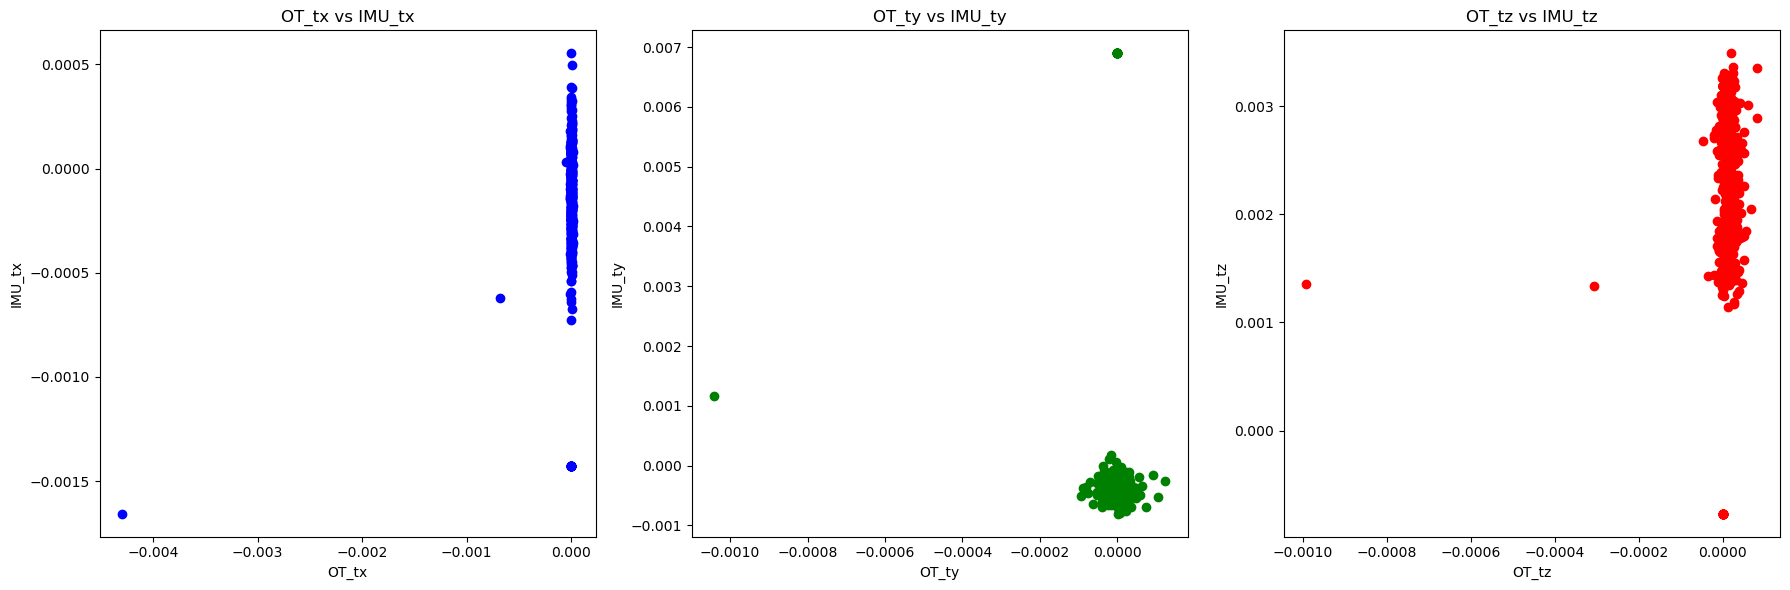

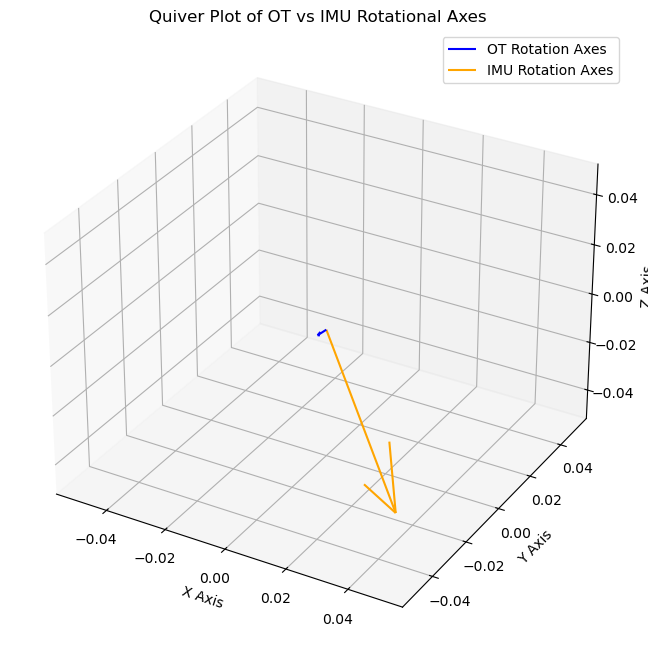

In [18]:
# Scatter plot for translation (X, Y, Z) comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter: ot_tx vs imu_tx, ot_ty vs imu_ty, ot_tz vs imu_tz
axes[0].scatter(
    all_target_displacements[:, 0], all_imu_displacements[:, 0], color="blue"
)
axes[0].set_title("OT_tx vs IMU_tx")
axes[0].set_xlabel("OT_tx")
axes[0].set_ylabel("IMU_tx")

axes[1].scatter(
    all_target_displacements[:, 1], all_imu_displacements[:, 1], color="green"
)
axes[1].set_title("OT_ty vs IMU_ty")
axes[1].set_xlabel("OT_ty")
axes[1].set_ylabel("IMU_ty")

axes[2].scatter(
    all_target_displacements[:, 2], all_imu_displacements[:, 2], color="red"
)
axes[2].set_title("OT_tz vs IMU_tz")
axes[2].set_xlabel("OT_tz")
axes[2].set_ylabel("IMU_tz")

plt.tight_layout()
plt.show()

# 3D Quiver plot for rotational axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot OT rotational axes as quivers
ax.quiver(
    0,
    0,
    0,
    all_target_angular_displacements[:, 0].mean(),
    all_target_angular_displacements[:, 1].mean(),
    all_target_angular_displacements[:, 2].mean(),
    color="blue",
    label="OT Rotation Axes",
)

# Plot IMU rotational axes as quivers
ax.quiver(
    0,
    0,
    0,
    all_imu_angular_displacements[:, 0].mean(),
    all_imu_angular_displacements[:, 1].mean(),
    all_imu_angular_displacements[:, 2].mean(),
    color="orange",
    label="IMU Rotation Axes",
)

# Set labels
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Quiver Plot of OT vs IMU Rotational Axes")
ax.legend()

plt.show()

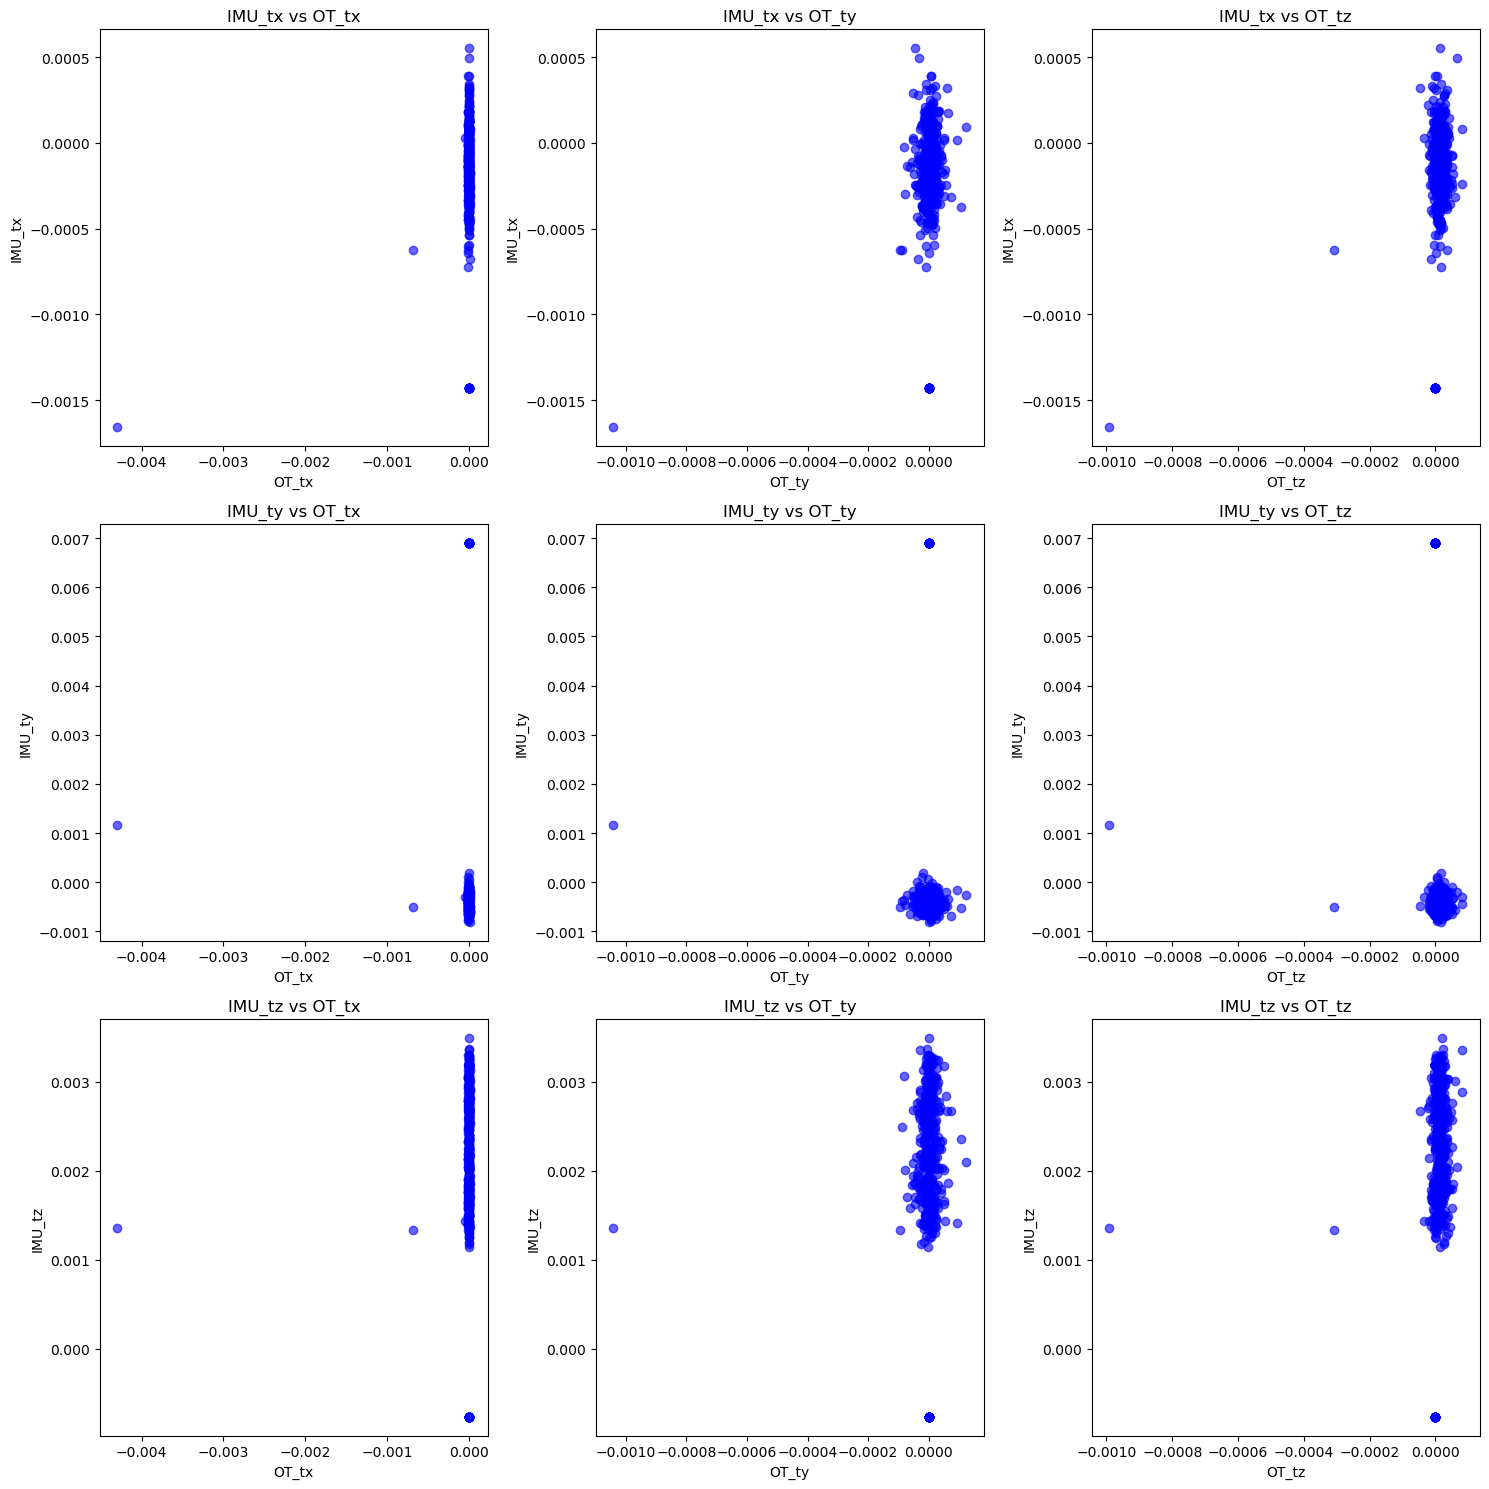

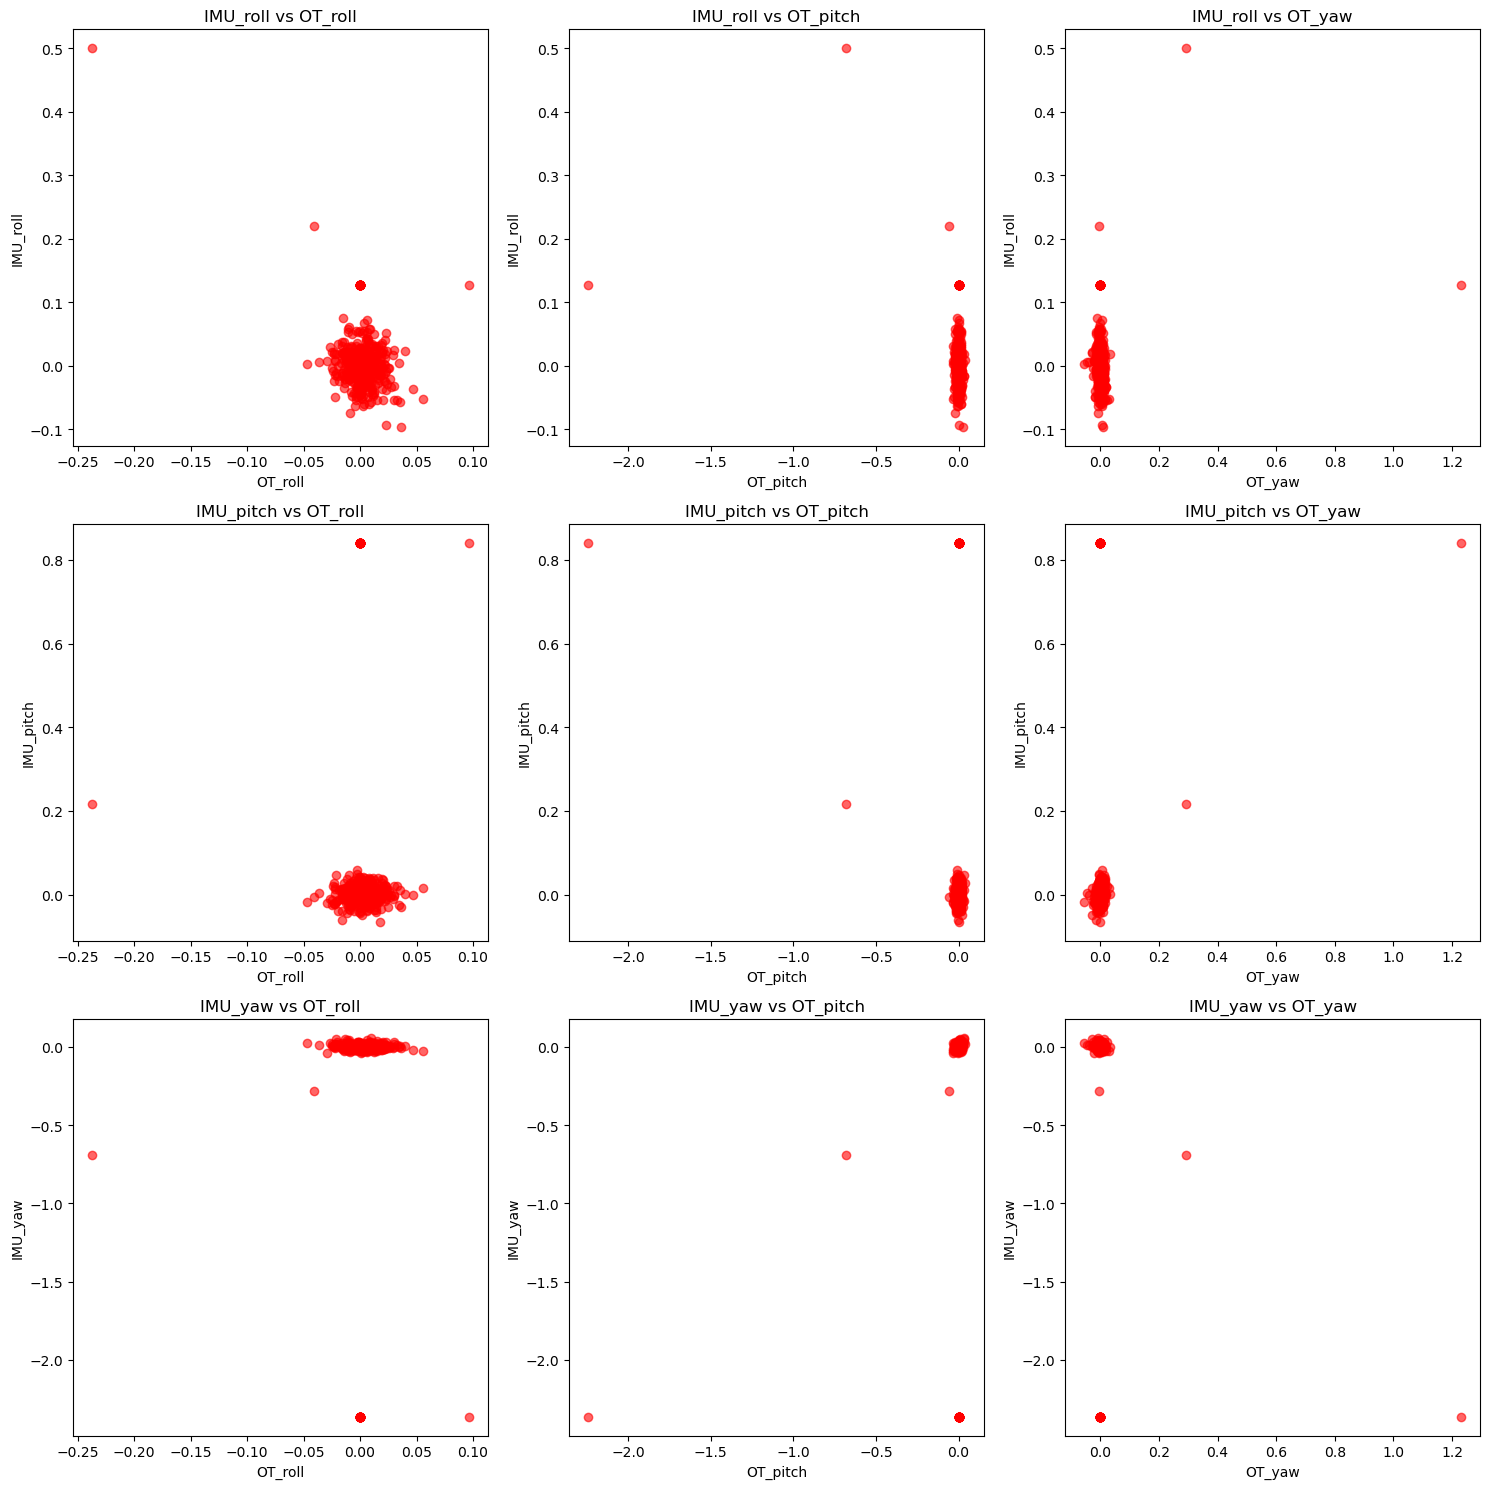

In [19]:
# Pairwise scatter plots for translation
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Titles and labels for the axes
imu_translation_labels = ["IMU_tx", "IMU_ty", "IMU_tz"]
ot_translation_labels = ["OT_tx", "OT_ty", "OT_tz"]

# Iterate over each IMU translation axis and OT translation axis
for i in range(3):
    for j in range(3):
        axes[i, j].scatter(
            all_target_displacements[:, j],
            all_imu_displacements[:, i],
            color="b",
            alpha=0.6,
        )
        axes[i, j].set_xlabel(ot_translation_labels[j])
        axes[i, j].set_ylabel(imu_translation_labels[i])
        axes[i, j].set_title(
            f"{imu_translation_labels[i]} vs {ot_translation_labels[j]}"
        )

plt.tight_layout()
plt.show()

# Pairwise scatter plots for rotation
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Titles and labels for the axes
imu_rotation_labels = ["IMU_roll", "IMU_pitch", "IMU_yaw"]
ot_rotation_labels = ["OT_roll", "OT_pitch", "OT_yaw"]

# Iterate over each IMU rotation axis and OT rotation axis
for i in range(3):
    for j in range(3):
        axes[i, j].scatter(
            all_target_angular_displacements[:, j],
            all_imu_angular_displacements[:, i],
            color="r",
            alpha=0.6,
        )
        axes[i, j].set_xlabel(ot_rotation_labels[j])
        axes[i, j].set_ylabel(imu_rotation_labels[i])
        axes[i, j].set_title(f"{imu_rotation_labels[i]} vs {ot_rotation_labels[j]}")

plt.tight_layout()
plt.show()

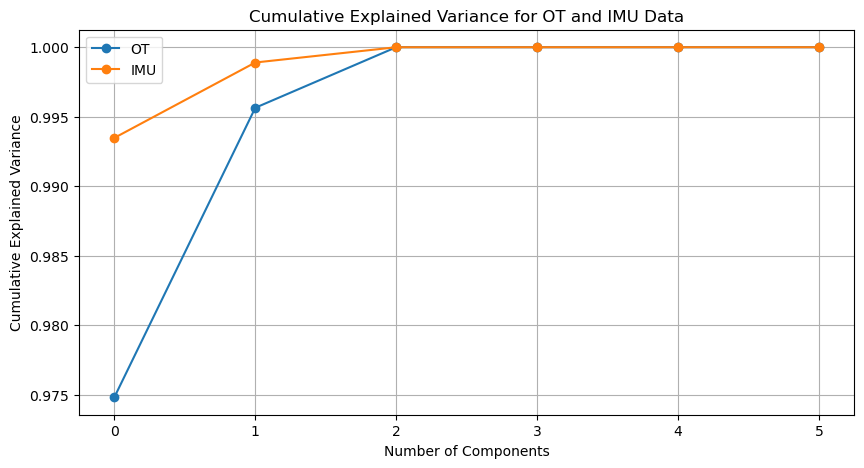

Principal Components for OT:
[[ 1.6135052e-03  3.8278967e-04  3.9599108e-04 -9.7987046e-03
   8.8069582e-01 -4.7357780e-01]
 [-9.3885354e-04 -7.6224026e-04  2.7229195e-04  9.1658193e-01
   1.9723135e-01  3.4781575e-01]
 [-7.1677670e-05 -7.7183504e-04  2.6936791e-04 -3.9972571e-01
   4.3066564e-01  8.0916363e-01]
 [ 9.6022820e-01  2.6384160e-01  9.1352530e-02  9.0529869e-04
  -1.1659898e-03  1.3741158e-03]
 [-2.6884872e-01  9.6201134e-01  4.7474701e-02  1.4446740e-04
   4.3942724e-04  7.1549992e-04]
 [-7.5356565e-02 -7.0146278e-02  9.9468619e-01 -2.2880007e-04
  -4.3511740e-04 -2.8615526e-04]]

Principal Components for IMU:
[[ 5.35853589e-04 -2.79832149e-03  1.23898344e-03 -5.72014576e-02
  -3.31381497e-01  9.41756149e-01]
 [-1.50413033e-03 -1.53149397e-03 -4.00656978e-03  9.36311389e-01
  -3.45152063e-01 -6.45784438e-02]
 [ 2.01294196e-03 -2.48580601e-03  7.91447412e-03  3.46471788e-01
   8.78059578e-01  3.29993649e-01]
 [-2.31799765e-02 -1.70385563e-01  9.85062675e-01  6.83067895e-04


In [20]:
# Concatenate translations and rotations for both OT and IMU
ot_data = np.hstack((all_target_displacements, all_target_angular_displacements))
imu_data = np.hstack((all_imu_displacements, all_imu_angular_displacements))

# Apply PCA to both OT and IMU data
pca_ot = PCA(n_components=6)
pca_imu = PCA(n_components=6)

pca_ot.fit(ot_data)
pca_imu.fit(imu_data)

# Plot the explained variance ratio for OT and IMU data
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_ot.explained_variance_ratio_), label="OT", marker="o")
plt.plot(np.cumsum(pca_imu.explained_variance_ratio_), label="IMU", marker="o")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.title("Cumulative Explained Variance for OT and IMU Data")
plt.grid(True)
plt.show()

# Print the principal components to see the major axes of variation
print("Principal Components for OT:")
print(pca_ot.components_)

print("\nPrincipal Components for IMU:")
print(pca_imu.components_)

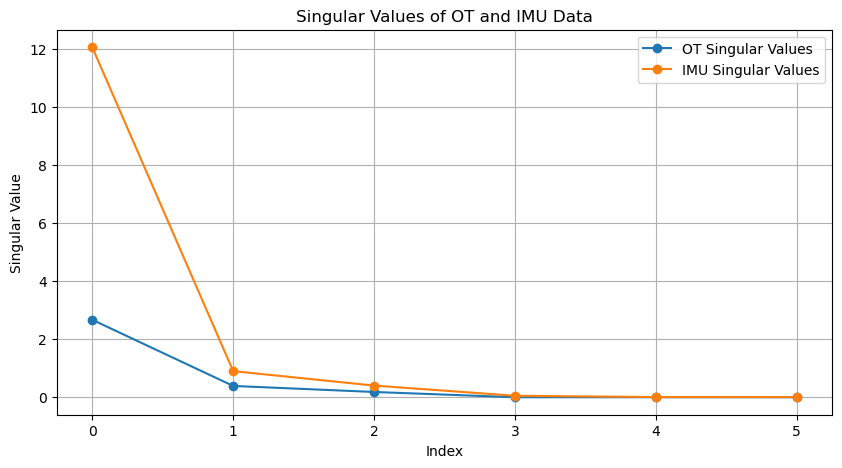

Estimated Rotation Matrix (R) aligning OT to IMU:
[[-2.53130118e-01 -1.48168094e-01  9.56018118e-01  8.90698237e-06
   8.30977244e-04  1.44899860e-04]
 [ 1.07221815e-01 -9.86373599e-01 -1.24476900e-01  1.57097498e-03
  -5.98332605e-03 -6.15149494e-03]
 [ 9.60710310e-01  7.06239263e-02  2.65296941e-01  4.46723441e-03
   1.79621303e-02  3.63719034e-02]
 [ 5.09068606e-03 -8.78527259e-04  1.27624951e-03 -9.97734687e-01
  -6.57946226e-02  1.29691325e-02]
 [-3.63776969e-02 -9.58719397e-03 -1.13987003e-02  2.69580377e-03
   1.50915001e-01  9.87761209e-01]
 [-1.07279738e-02 -5.73751179e-03 -4.56340760e-03 -6.70503992e-02
   9.86172733e-01 -1.50992763e-01]]


In [21]:
# Apply SVD to the concatenated OT and IMU data
U_ot, S_ot, Vt_ot = svd(ot_data, full_matrices=False)
U_imu, S_imu, Vt_imu = svd(imu_data, full_matrices=False)

# Plot singular values to compare OT and IMU
plt.figure(figsize=(10, 5))
plt.plot(S_ot, label="OT Singular Values", marker="o")
plt.plot(S_imu, label="IMU Singular Values", marker="o")
plt.xlabel("Index")
plt.ylabel("Singular Value")
plt.legend()
plt.title("Singular Values of OT and IMU Data")
plt.grid(True)
plt.show()

# The transformation matrix that best aligns OT to IMU can be estimated as:
# Rotation matrix: R = Vt_imu.T @ Vt_ot
R = Vt_imu.T @ Vt_ot

# Print the estimated rotation matrix
print("Estimated Rotation Matrix (R) aligning OT to IMU:")
print(R)

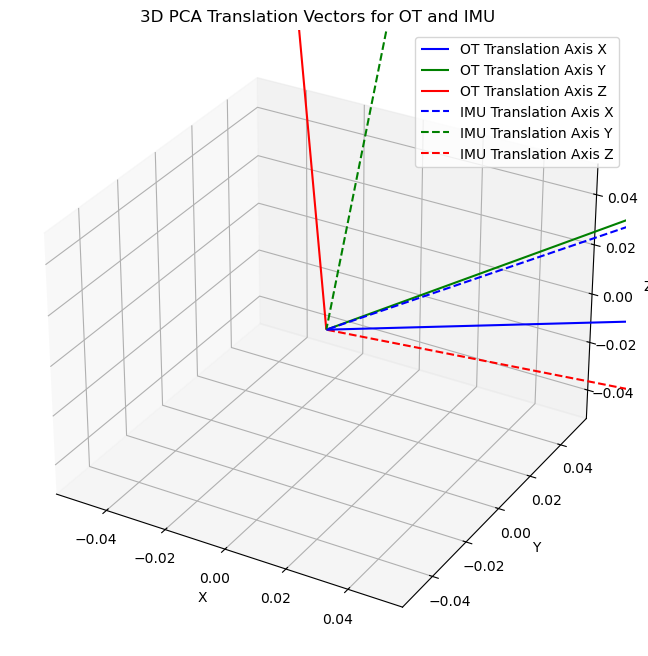

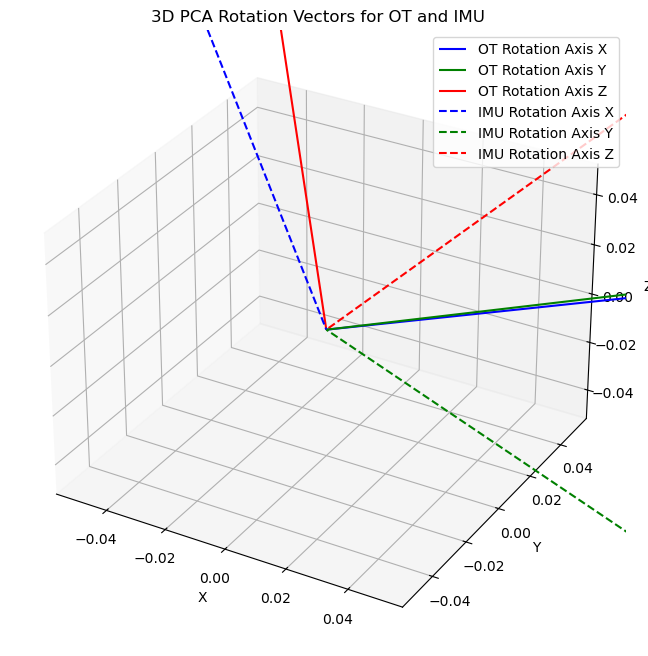

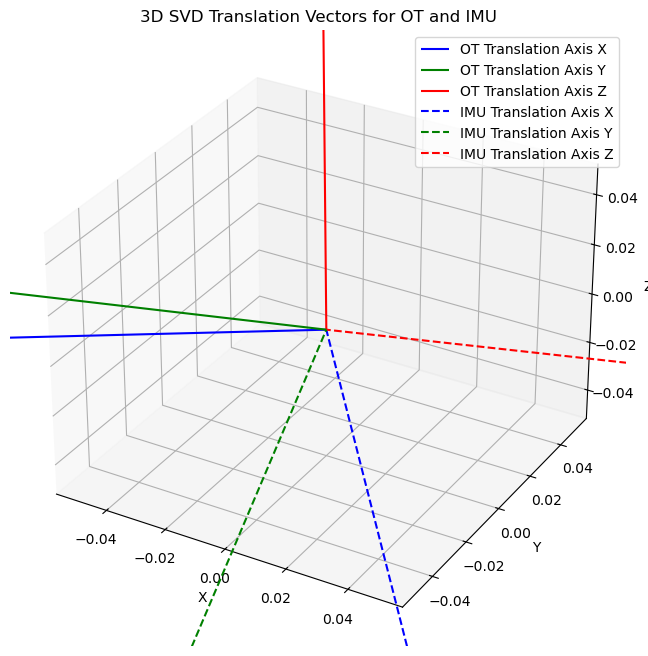

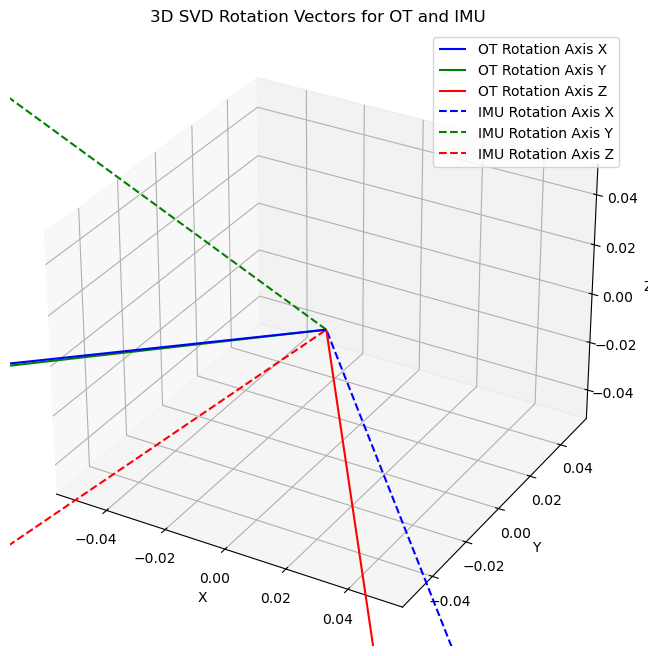

In [22]:
# Function to plot 3D unit vectors for translation and rotation separately
def plot_3d_unit_vectors(
    vectors_ot, vectors_imu, method="PCA", component="Translation"
):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Origin for the vectors
    origin = np.zeros((3, 3))

    # Colors for each axis
    colors = ["blue", "green", "red"]  # X, Y, Z

    # Plot OT unit vectors (solid lines)
    for i in range(3):
        ax.quiver(
            origin[i, 0],
            origin[i, 1],
            origin[i, 2],
            vectors_ot[i, 0],
            vectors_ot[i, 1],
            vectors_ot[i, 2],
            color=colors[i],
            linestyle="-",
            label=f'OT {component} Axis {["X", "Y", "Z"][i]}',
        )

    # Plot IMU unit vectors (dashed lines)
    for i in range(3):
        ax.quiver(
            origin[i, 0],
            origin[i, 1],
            origin[i, 2],
            vectors_imu[i, 0],
            vectors_imu[i, 1],
            vectors_imu[i, 2],
            color=colors[i],
            linestyle="--",
            label=f'IMU {component} Axis {["X", "Y", "Z"][i]}',
        )

    # Set labels and legend
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.legend()
    ax.set_title(f"3D {method} {component} Vectors for OT and IMU")

    plt.show()


# PCA for translation and rotation
pca_ot_translation = PCA(n_components=3)
pca_imu_translation = PCA(n_components=3)
pca_ot_translation.fit(all_target_displacements)
pca_imu_translation.fit(all_imu_displacements)

pca_ot_rotation = PCA(n_components=3)
pca_imu_rotation = PCA(n_components=3)
pca_ot_rotation.fit(all_target_angular_displacements)
pca_imu_rotation.fit(all_imu_angular_displacements)

# SVD for translation and rotation
U_ot_translation, S_ot_translation, Vt_ot_translation = svd(
    all_target_displacements, full_matrices=False
)
U_imu_translation, S_imu_translation, Vt_imu_translation = svd(
    all_imu_displacements, full_matrices=False
)

U_ot_rotation, S_ot_rotation, Vt_ot_rotation = svd(
    all_target_angular_displacements, full_matrices=False
)
U_imu_rotation, S_imu_rotation, Vt_imu_rotation = svd(
    all_imu_angular_displacements, full_matrices=False
)

# Plot PCA unit vectors for translation
plot_3d_unit_vectors(
    pca_ot_translation.components_,
    pca_imu_translation.components_,
    method="PCA",
    component="Translation",
)

# Plot PCA unit vectors for rotation
plot_3d_unit_vectors(
    pca_ot_rotation.components_,
    pca_imu_rotation.components_,
    method="PCA",
    component="Rotation",
)

# Plot SVD unit vectors for translation
plot_3d_unit_vectors(
    Vt_ot_translation[:3], Vt_imu_translation[:3], method="SVD", component="Translation"
)

# Plot SVD unit vectors for rotation
plot_3d_unit_vectors(
    Vt_ot_rotation[:3], Vt_imu_rotation[:3], method="SVD", component="Rotation"
)

In [23]:
import numpy as np


def estimate_transformation_matrix(imu_data, ot_data):
    """
    Estimate the best rotation matrix to align IMU data with OT data using SVD.

    Args:
        imu_data (np.ndarray): IMU data (Nx3 or Nx6 for translation or rotation).
        ot_data (np.ndarray): OT data (Nx3 or Nx6 for translation or rotation).

    Returns:
        R (np.ndarray): The estimated rotation matrix (3x3).
        t (np.ndarray): The translation vector (3x1), if translation is needed.
    """
    # 1. Center the data (translation and rotation separately)
    imu_mean = np.mean(imu_data, axis=0)
    ot_mean = np.mean(ot_data, axis=0)

    imu_centered = imu_data - imu_mean
    ot_centered = ot_data - ot_mean

    # 2. Compute the covariance matrix
    covariance_matrix = imu_centered.T @ ot_centered

    # 3. Apply SVD to the covariance matrix
    U, S, Vt = svd(covariance_matrix)

    # 4. Compute the rotation matrix (R)
    R = Vt.T @ U.T

    # Ensure a valid rotation (no reflection) by adjusting the sign of R
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    # 5. Translation vector (optional, for translation alignment)
    t = ot_mean.T - R @ imu_mean.T

    return R, t


# Estimate the best rotation and translation matrices for translation data
R_translation, t_translation = estimate_transformation_matrix(
    all_imu_displacements, all_target_displacements
)

# Estimate the best rotation and translation matrices for rotation data
R_rotation, t_rotation = estimate_transformation_matrix(
    all_imu_angular_displacements, all_target_angular_displacements
)

# Print the results
print("Estimated Rotation Matrix for Translation:")
print(R_translation)
print("\nEstimated Translation Vector for Translation:")
print(t_translation)

print("\nEstimated Rotation Matrix for Rotation:")
print(R_rotation)
print("\nEstimated Translation Vector for Rotation (if applicable):")
print(t_rotation)

Estimated Rotation Matrix for Translation:
[[ 0.90567065 -0.26616918  0.33002218]
 [-0.35877483 -0.0663503   0.93106297]
 [-0.2259232  -0.96164006 -0.15558633]]

Estimated Translation Vector for Translation:
[-0.00064919 -0.00219407  0.00024936]

Estimated Rotation Matrix for Rotation:
[[-0.9532076  -0.23637073 -0.18847828]
 [-0.22912942  0.1581478   0.9604629 ]
 [-0.1972179   0.95870656 -0.20490713]]

Estimated Translation Vector for Rotation (if applicable):
[-0.01007602  0.09006032 -0.06491969]


In [24]:
# Apply the estimated rotation and translation to IMU data (translation example)
aligned_imu_translation = (R_translation @ all_imu_displacements.T).T + t_translation

# Apply the estimated rotation to IMU data (rotation example)
aligned_imu_rotation = (R_rotation @ all_imu_angular_displacements.T).T

# Now aligned_imu_translation and aligned_imu_rotation should be aligned with OT data

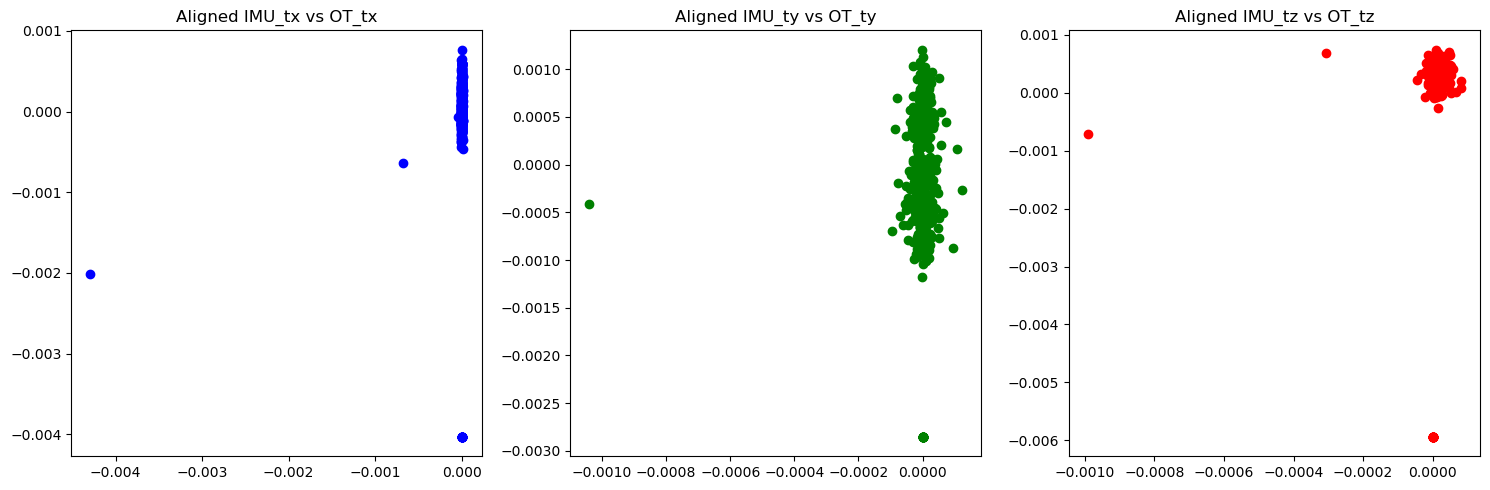

In [25]:
# Plot aligned IMU translation vs. OT translation
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# X, Y, Z comparisons for translation
axes[0].scatter(
    all_target_displacements[:, 0], aligned_imu_translation[:, 0], color="b"
)
axes[0].set_title("Aligned IMU_tx vs OT_tx")

axes[1].scatter(
    all_target_displacements[:, 1], aligned_imu_translation[:, 1], color="g"
)
axes[1].set_title("Aligned IMU_ty vs OT_ty")

axes[2].scatter(
    all_target_displacements[:, 2], aligned_imu_translation[:, 2], color="r"
)
axes[2].set_title("Aligned IMU_tz vs OT_tz")

plt.tight_layout()
plt.show()

In [26]:
def align_unit_vectors(vectors_imu, vectors_ot):
    """
    Compute the best rotation matrix to align the IMU unit vectors with OT unit vectors.

    Args:
        vectors_imu (np.ndarray): IMU unit vectors (3x3 or 6x3).
        vectors_ot (np.ndarray): OT unit vectors (3x3 or 6x3).

    Returns:
        R (np.ndarray): The optimal rotation matrix that aligns IMU with OT (3x3).
    """
    # 1. Compute the covariance matrix between the IMU and OT unit vectors
    H = vectors_imu.T @ vectors_ot

    # 2. Perform SVD on the covariance matrix
    U, S, Vt = svd(H)

    # 3. Compute the rotation matrix
    R = Vt.T @ U.T

    # Ensure a valid rotation (no reflection)
    if np.linalg.det(R) < 0:
        Vt[-1, :] *= -1
        R = Vt.T @ U.T

    return R


# PCA unit vectors for translation and rotation
pca_vectors_imu_translation = pca_imu_translation.components_
pca_vectors_ot_translation = pca_ot_translation.components_

pca_vectors_imu_rotation = pca_imu_rotation.components_
pca_vectors_ot_rotation = pca_ot_rotation.components_

# Estimate the rotation matrix using PCA unit vectors for translation
R_pca_translation = align_unit_vectors(
    pca_vectors_imu_translation, pca_vectors_ot_translation
)

# Estimate the rotation matrix using PCA unit vectors for rotation
R_pca_rotation = align_unit_vectors(pca_vectors_imu_rotation, pca_vectors_ot_rotation)

# Print the estimated rotation matrices
print("Estimated Rotation Matrix from PCA for Translation:")
print(R_pca_translation)

print("\nEstimated Rotation Matrix from PCA for Rotation:")
print(R_pca_rotation)

# Similarly for SVD:
svd_vectors_imu_translation = Vt_imu_translation[:3]
svd_vectors_ot_translation = Vt_ot_translation[:3]

svd_vectors_imu_rotation = Vt_imu_rotation[:3]
svd_vectors_ot_rotation = Vt_ot_rotation[:3]

# Estimate the rotation matrix using SVD unit vectors for translation
R_svd_translation = align_unit_vectors(
    svd_vectors_imu_translation, svd_vectors_ot_translation
)

# Estimate the rotation matrix using SVD unit vectors for rotation
R_svd_rotation = align_unit_vectors(svd_vectors_imu_rotation, svd_vectors_ot_rotation)

# Print the estimated rotation matrices from SVD
print("\nEstimated Rotation Matrix from SVD for Translation:")
print(R_svd_translation)

print("\nEstimated Rotation Matrix from SVD for Rotation:")
print(R_svd_rotation)

Estimated Rotation Matrix from PCA for Translation:
[[-0.44235585  0.72743045 -0.52456291]
 [ 0.26521522  0.66484539  0.69831332]
 [ 0.8567276   0.16978091 -0.48702387]]

Estimated Rotation Matrix from PCA for Rotation:
[[ 0.96665674  0.25305775 -0.03919887]
 [ 0.15547574 -0.4583542   0.87506497]
 [ 0.203475   -0.85198194 -0.4824155 ]]

Estimated Rotation Matrix from SVD for Translation:
[[ 0.13037046 -0.49359219  0.85986644]
 [ 0.10948568  0.86913136  0.48231066]
 [-0.98540166  0.031264    0.16735033]]

Estimated Rotation Matrix from SVD for Rotation:
[[ 0.6896558  -0.59824675 -0.40801436]
 [ 0.20995112  0.70443904 -0.6780016 ]
 [ 0.6930336   0.3819246   0.6114231 ]]


In [27]:
# Apply the estimated rotation matrix to align IMU translation unit vectors with OT
aligned_imu_translation = (R_pca_translation @ all_imu_displacements.T).T

# Apply the estimated rotation matrix to align IMU rotation unit vectors with OT
aligned_imu_rotation = (R_pca_rotation @ all_imu_angular_displacements.T).T

# You can visualize the aligned data to verify the alignment

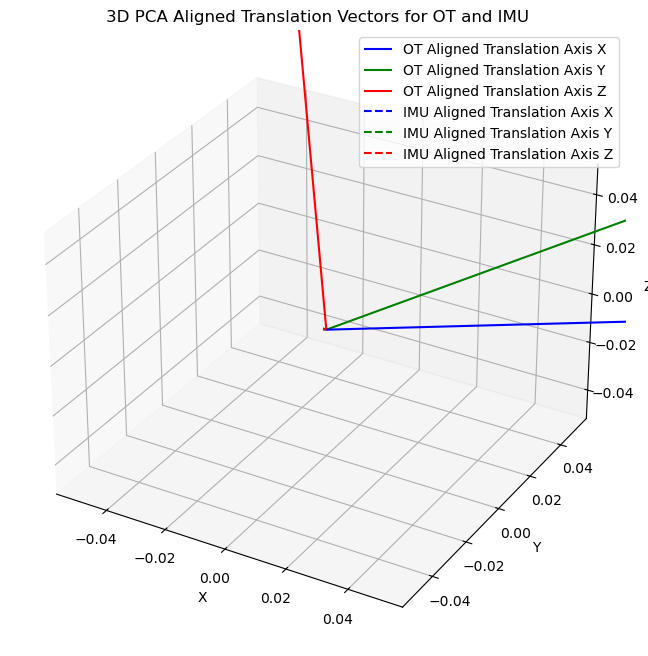

In [28]:
# Plot aligned unit vectors (for example, for PCA translation)
plot_3d_unit_vectors(
    pca_vectors_ot_translation,
    aligned_imu_translation[:3],
    method="PCA",
    component="Aligned Translation",
)

In [29]:
# check number of scans in each split

logger.info(f"Train dataset: {len(train_dataset)} samples")
logger.info(f"Val dataset: {len(val_dataset)} samples")
logger.info(f"Test dataset: {len(test_dataset)} samples")

[09/06/24 11:38:34] INFO     INFO:rich:Train dataset: 1499 samples                                  ]8;id=94148;file:///tmp/ipykernel_1816552/3174490196.py\3174490196.py]8;;\:]8;id=245701;file:///tmp/ipykernel_1816552/3174490196.py#3\3]8;;\

                    INFO     INFO:rich:Val dataset: 499 samples                                     ]8;id=101258;file:///tmp/ipykernel_1816552/3174490196.py\3174490196.py]8;;\:]8;id=194071;file:///tmp/ipykernel_1816552/3174490196.py#4\4]8;;\

                    INFO     INFO:rich:Test dataset: 499 samples                                    ]8;id=39058;file:///tmp/ipykernel_1816552/3174490196.py\3174490196.py]8;;\:]8;id=768258;file:///tmp/ipykernel_1816552/3174490196.py#5\5]8;;\

In [30]:
# Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    train_dataset, val_dataset, test_dataset, BATCH_SIZE_TRAIN, BATCH_SIZE_VAL
)

                    INFO     INFO:rich:Training samples: 1499, Validation samples: 499, Test      ]8;id=5346;file:///tmp/ipykernel_1816552/3322855690.py\3322855690.py]8;;\:]8;id=332215;file:///tmp/ipykernel_1816552/3322855690.py#100\100]8;;\
                             samples: 499                                                                          

In [31]:
1 / float(SAMPLING_RATE)

0.1

Frames shape: torch.Size([8, 2, 3, 333, 219])
IMU data shape: torch.Size([8, 2, 6])
Target shape: torch.Size([8, 6])


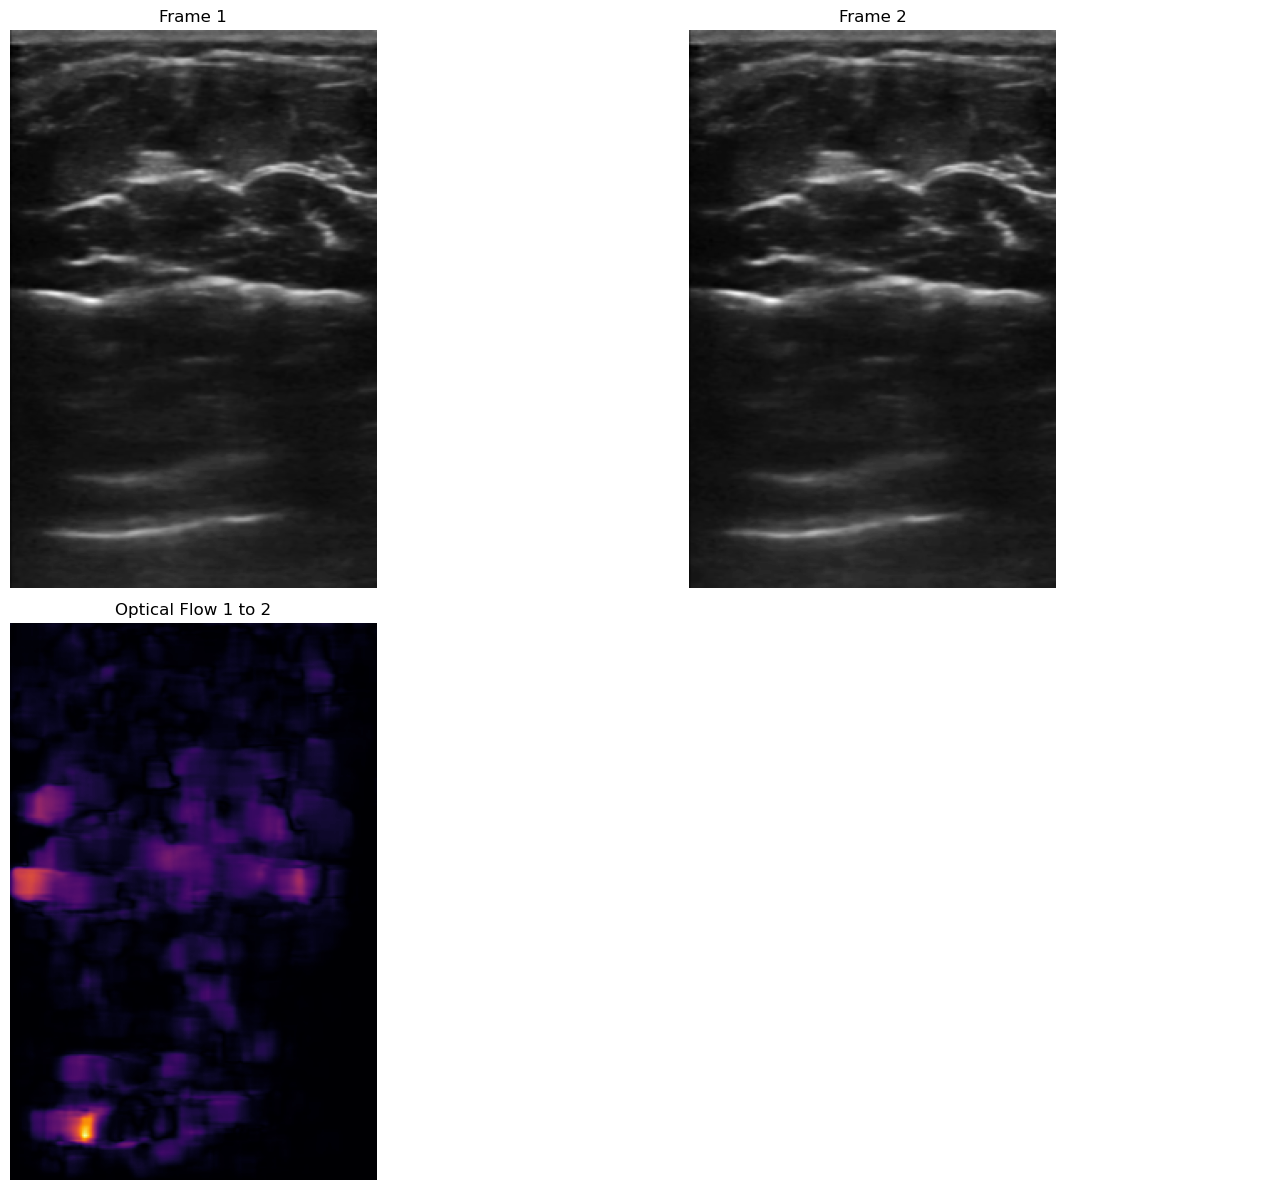

IMU data for first sample in batch:
tensor([[ 0.0015, -0.0373,  0.1427,  0.0011,  0.0202, -0.0096],
        [ 0.0015, -0.0373,  0.1427,  0.0011,  0.0202, -0.0096]])
Target for first sample in batch:
tensor([0., 0., 0., 0., 0., 0.])


In [32]:
# Fetch a batch of data from the train_loader
frames, imu_data, target = next(iter(train_loader))

# Print the shapes of the data to understand their structure
print(f"Frames shape: {frames.shape}")  # Should be (batch_size, seq_len, C, H, W)
print(f"IMU data shape: {imu_data.shape}")  # Should be (batch_size, seq_len, 6)
print(f"Target shape: {target.shape}")  # Should be (batch_size, 6)

# Visualize the frames in the first batch
batch_size, seq_len, C, H, W = frames.shape

fig, axes = plt.subplots(2, seq_len, figsize=(15, 12))

for i in range(seq_len):
    frame = (
        frames[0, i].permute(1, 2, 0).numpy()
    )  # Get the ith frame in the first batch and permute to (H, W, C)
    axes[0, i].imshow(np.mean(frame, axis=-1), cmap="gray")
    axes[0, i].set_title(f"Frame {i+1}")
    axes[0, i].axis("off")

    if i < seq_len - 1:
        # Calculate optical flow between frame i and frame i+1
        prev_frame = np.mean(frames[0, i].permute(1, 2, 0).numpy(), axis=-1)
        next_frame = np.mean(frames[0, i + 1].permute(1, 2, 0).numpy(), axis=-1)
        flow = cv2.calcOpticalFlowFarneback(
            prev_frame, next_frame, None, 0.5, 3, 15, 3, 5, 1.2, 0
        )

        # Convert flow to magnitude and angle for visualization
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        flow_visualization = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
        flow_visualization = np.uint8(flow_visualization)

        axes[1, i].imshow(flow_visualization, cmap="inferno")
        axes[1, i].set_title(f"Optical Flow {i+1} to {i+2}")
        axes[1, i].axis("off")
    else:
        axes[1, i].axis(
            "off"
        )  # Hide the last optical flow axis since there's no frame after the last one

plt.tight_layout()
plt.show()

# Also print out the first IMU data pair and the corresponding target for inspection
print("IMU data for first sample in batch:")
print(imu_data[0])  # Should be (seq_len, 6)
print("Target for first sample in batch:")
print(target[0])  # Should be (6)

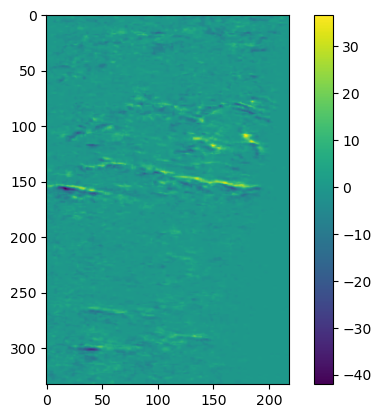

In [33]:
plt.imshow(next_frame - prev_frame)
plt.colorbar()

In [34]:
# Initialize the Madgwick filter
madgwick = Madgwick()

# Assume we're only processing the first sample in the batch
imu_data_sample = imu_data[0].numpy()  # Shape: (2, 6) for two timesteps
target_sample = target[0].numpy()  # Shape: (6)

# Initialize orientation state
orientation = np.array([1, 0, 0, 0]).astype(np.float64)  # Quaternion (w, x, y, z)

# Initialize variables for displacement and orientation
velocity = np.zeros(3)
position = np.zeros(3)

# Process the IMU data sequence
for i in range(imu_data_sample.shape[0]):
    # Extract accelerometer and gyroscope data
    acc = imu_data_sample[i, :3]  # First three elements are acceleration (X, Y, Z)
    gyro = imu_data_sample[i, 3:6]  # Next three elements are gyroscope (X, Y, Z)

    # Apply Madgwick filter to update orientation
    orientation = madgwick.updateIMU(q=orientation, gyr=gyro, acc=acc)

    # Update velocity and position (integrating acceleration to get displacement)
    delta_t = 1 / float(SAMPLING_RATE)  # Adjust delta_t as per your sampling rate
    # acc[2] -= 9.81  # Subtract gravity from z-axis (assuming stationary start)
    velocity += acc * delta_t
    position += velocity * delta_t

# Convert final quaternion orientation to Euler angles
madgwick_euler = Rotation.from_quat(orientation).as_euler("xyz")

# The final Madgwick estimated displacement and angular displacement
madgwick_displacement = np.hstack((position, madgwick_euler))  # Shape: (6)

# Compute the error between Madgwick estimates and the target
error = madgwick_displacement - target_sample

# Print the results
print("Madgwick estimated displacement:", position)
print("Madgwick estimated angular displacement (Euler angles):", madgwick_euler)
print("Target displacement:", target_sample[:3])
print("Target angular displacement:", target_sample[3:])
print("Error:", error)

Madgwick estimated displacement: [ 4.59372997e-05 -1.11766581e-03  4.28112494e-03]
Madgwick estimated angular displacement (Euler angles): [-3.14140066e+00 -3.49712985e-04 -1.29760620e-03]
Target displacement: [0. 0. 0.]
Target angular displacement: [0. 0. 0.]
Error: [ 4.59372997e-05 -1.11766581e-03  4.28112494e-03 -3.14140066e+00
 -3.49712985e-04 -1.29760620e-03]


In [35]:
# Model setup
model = PoseEstimationModelDisplacement().to(DEVICE)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5, verbose=True
)

/home/varun/mambaforge/envs/abusfusion/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/varun/mambaforge/envs/abusfusion/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/varun/mambaforge/envs/abusfusion/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [36]:
# # Training loop with early stopping
# best_val_loss = float("inf")
# best_epoch = 0
# epochs_no_improve = 0

# with Progress() as progress:
#     epoch_task = progress.add_task("Training", total=NUM_EPOCHS)

#     for epoch in range(NUM_EPOCHS):
#         model.train()
#         train_loss = 0.0

#         # Progress tracking for batches
#         batch_task = progress.add_task(
#             f"Epoch {epoch+1}/{NUM_EPOCHS} Batches", total=len(train_loader)
#         )

#         for frames, imu_data, targets in train_loader:
#             frames, imu_data, targets = (
#                 frames.to(DEVICE),
#                 imu_data.to(DEVICE),
#                 targets.to(DEVICE),
#             )
#             optimizer.zero_grad()

#             outputs = model(frames, imu_data)
#             loss = criterion(outputs, targets)

#             loss.backward()
#             optimizer.step()

#             train_loss += loss.item()
#             progress.advance(batch_task)

#         # Validation phase
#         val_loss = validate_model(model, val_loader, criterion)
#         scheduler.step(val_loss)

#         # Progress update for the epoch
#         progress.update(epoch_task, advance=1)

#         logger.info(
#             f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}"
#         )

#         # Early stopping logic and saving the best model weights
#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_epoch = epoch + 1
#             torch.save(
#                 model.state_dict(), f"{MODEL_SAVE_DIR}_{MODEL_TYPE}_best_epoch.pth"
#             )
#             logger.info(
#                 f"Best model saved at epoch {best_epoch} with validation loss: {best_val_loss:.4f}"
#             )
#             epochs_no_improve = 0
#         else:
#             epochs_no_improve += 1

#         if epochs_no_improve >= PATIENCE:
#             logger.info("Early stopping triggered")
#             break

In [37]:
# Load the best model weights
model.load_state_dict(torch.load(f"{MODEL_SAVE_DIR}_{MODEL_TYPE}_best_epoch.pth"))

# Evaluate the model on the test set
test_loss, test_predictions, test_targets = evaluate_model(
    model, test_loader, criterion
)
logger.info(f"Test Loss: {test_loss:.4f}")

/tmp/ipykernel_1816552/1873010265.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{MODEL_SAVE_DIR}_{MODEL_TYPE}_best_epoch.pth"))


[09/06/24 11:38:42] INFO     INFO:rich:Test Loss: 0.0205                                            ]8;id=746866;file:///tmp/ipykernel_1816552/1873010265.py\1873010265.py]8;;\:]8;id=473525;file:///tmp/ipykernel_1816552/1873010265.py#8\8]8;;\

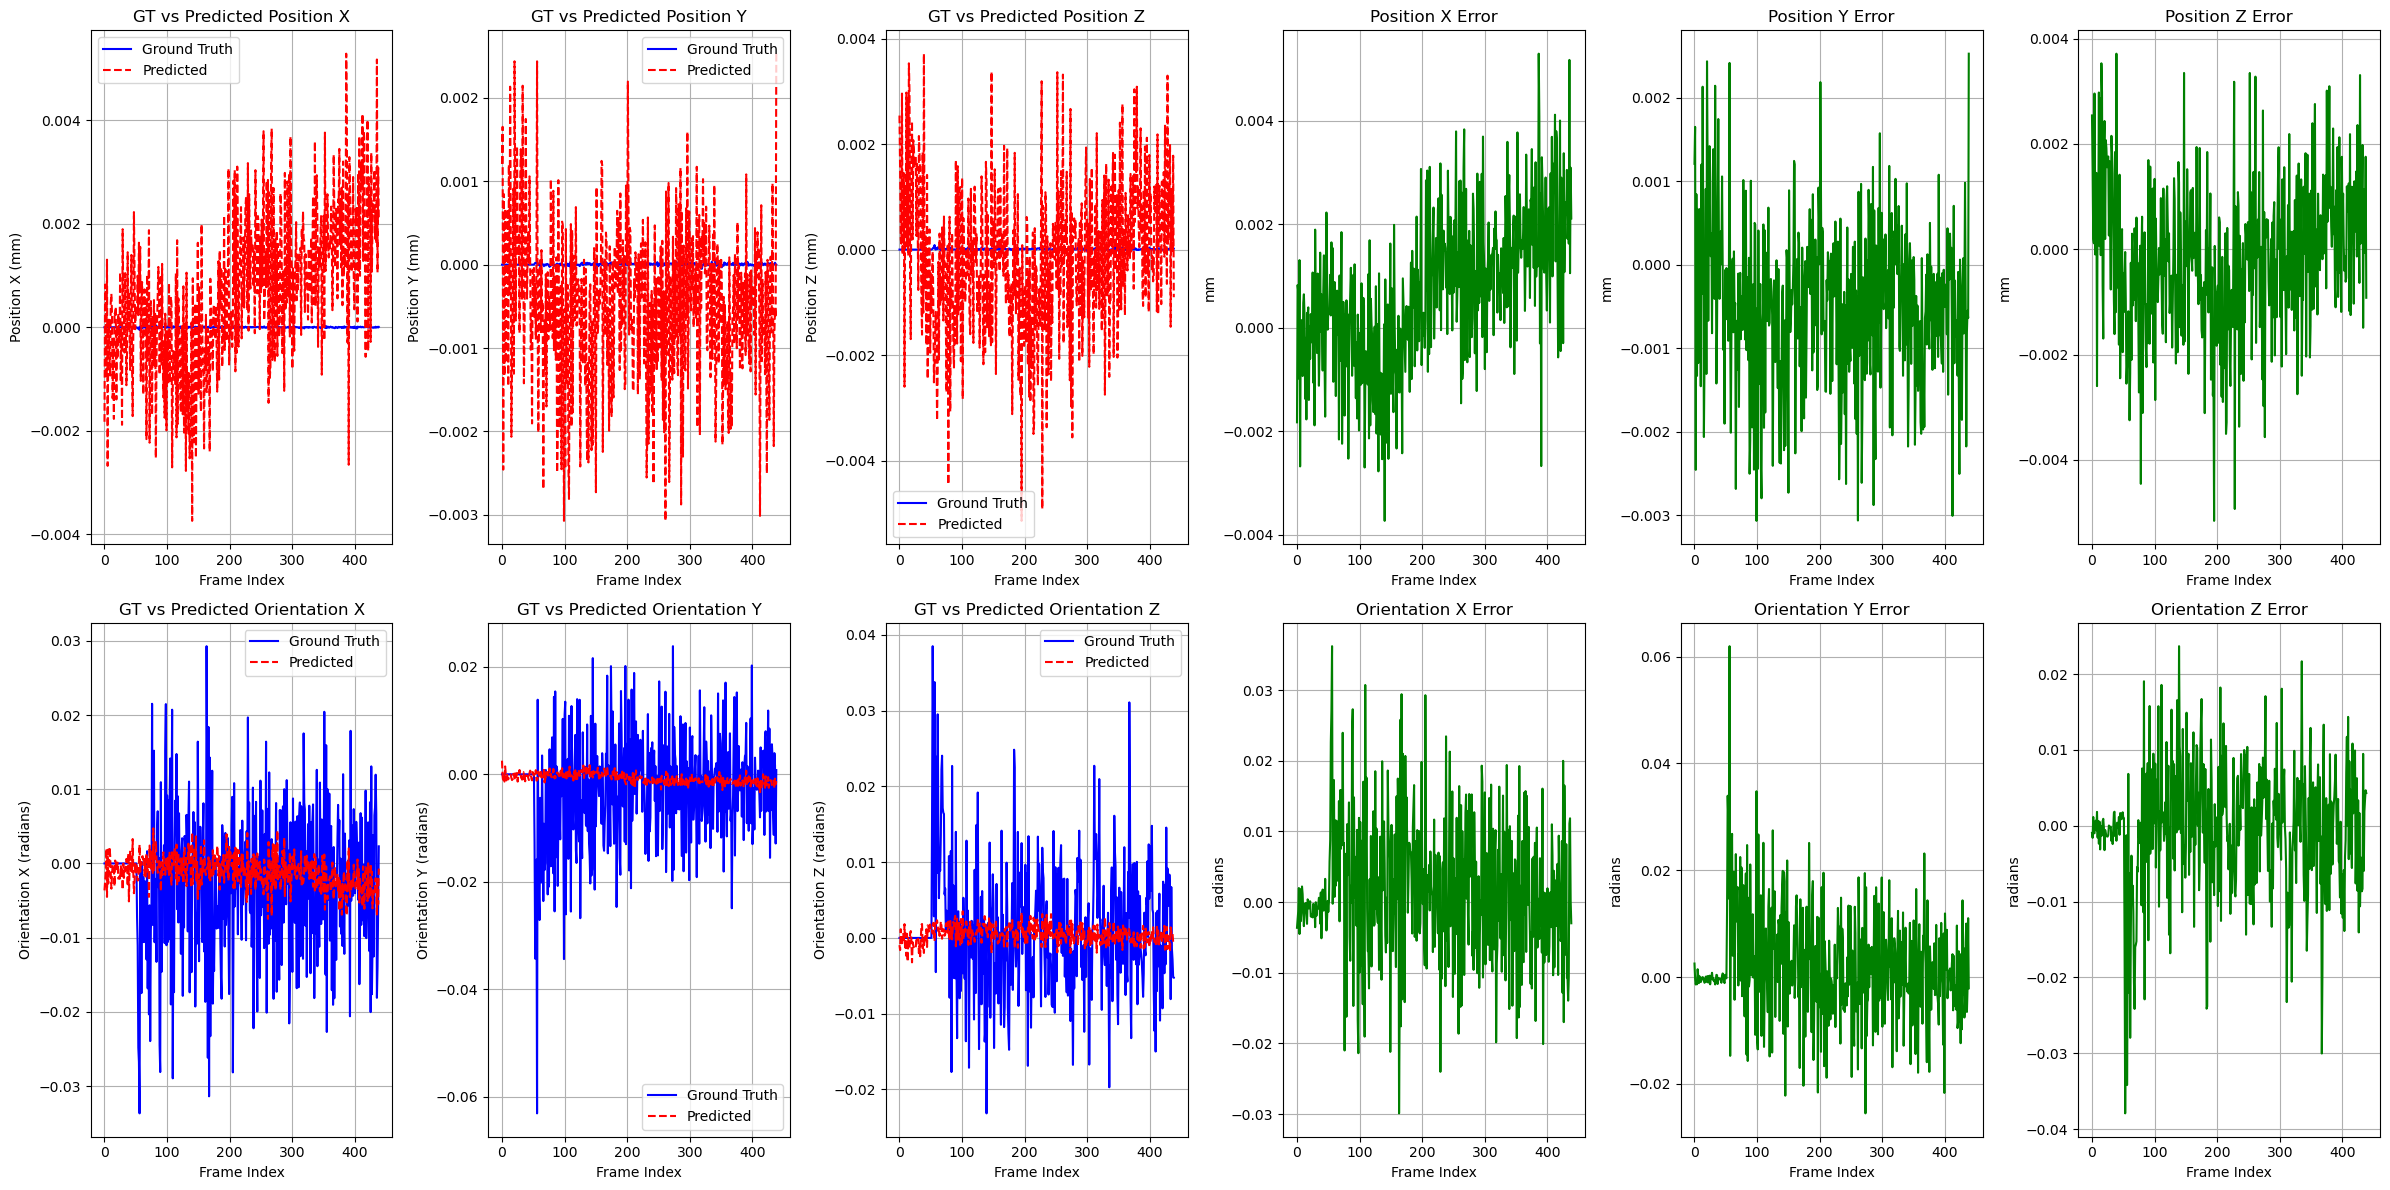

Reconstructing ground truth volume...


  0%|          | 0/440 [00:00<?, ?it/s]

In [51]:
# Truncate the dataset's frames before reconstruction
truncated_df = test_dataset.df.iloc[:-60]  # Discard the last 50 frames

# Plotting errors and trajecto|ries
plot_position_orientation_errors(test_predictions[:-60], test_targets[:-60], config)

# Perform ground truth volume reconstruction using the truncated data
ground_truth_volume, volume_origin, voxel_size, gt_centers, gt_orientations = (
    reconstruct_ground_truth_volume(
        truncated_df, PROBE_SPECS  # Passing the truncated dataframe
    )
)

In [52]:
ground_truth_volume.shape

(656, 790, 508)

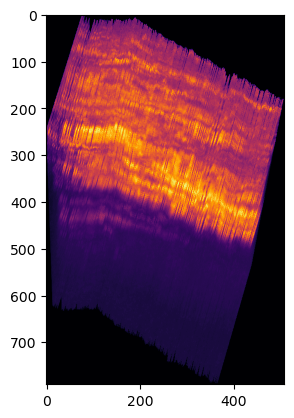

In [53]:
plt.imshow(np.max(ground_truth_volume, axis=0), cmap="inferno")

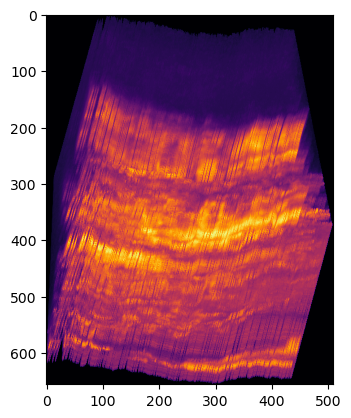

In [54]:
plt.imshow(np.max(ground_truth_volume, axis=1), cmap="inferno")

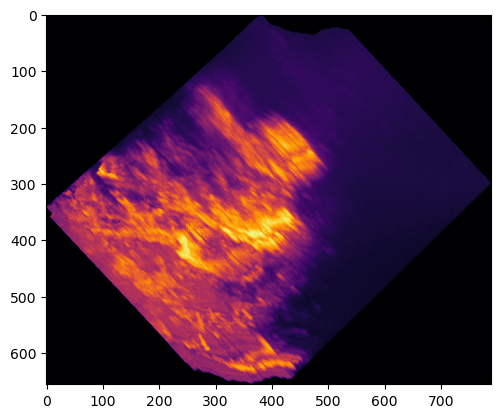

In [55]:
plt.imshow(np.max(ground_truth_volume, axis=2), cmap="inferno")

In [56]:
def downsample_framewise(volume, voxel_size, downsample_factor):
    downsampled_frames = []

    # Downsample each frame independently
    for i in tqdm(range(volume.shape[0])):
        downsampled_frame = volume[i][::downsample_factor]
        downsampled_frames.append(downsampled_frame)

    # Convert the list of downsampled frames to a NumPy array
    downsampled_volume = np.array(downsampled_frames)

    # Adjust the voxel size according to the downsampling factor
    new_voxel_size = voxel_size * downsample_factor
    return downsampled_volume, new_voxel_size


# Downsample the ground truth volume
downsampled_volume, new_voxel_size = downsample_framewise(
    ground_truth_volume, voxel_size, downsample_factor=4
)

np.save("downsampled_gt_volume.npy", downsampled_volume)

  0%|          | 0/656 [00:00<?, ?it/s]

Reconstructing predicted volume...


  0%|          | 0/439 [00:00<?, ?it/s]

MemoryError: Unable to allocate 48.0 TiB for an array with shape (36254, 22725, 16022) and data type float32

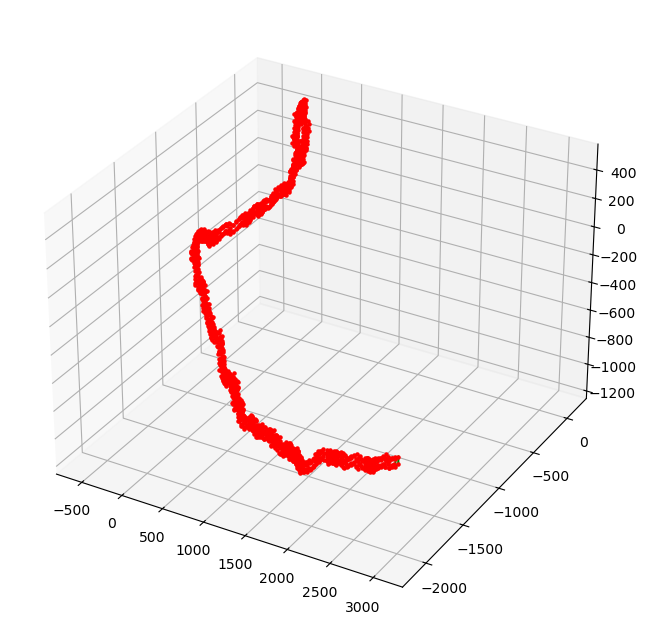

In [60]:
# Inference and prediction
all_frames, all_predictions = inference_and_prediction(test_loader, model)

# Truncate the last 60 frames for both frames and predictions
truncated_frames = all_frames[:-60, :]  # Discard the last 60 frames
truncated_predictions = all_predictions[:-60, :]  # Discard the last 60 predictions

Reconstructing predicted volume...


  0%|          | 0/439 [00:00<?, ?it/s]

  0%|          | 0/439 [00:00<?, ?it/s]

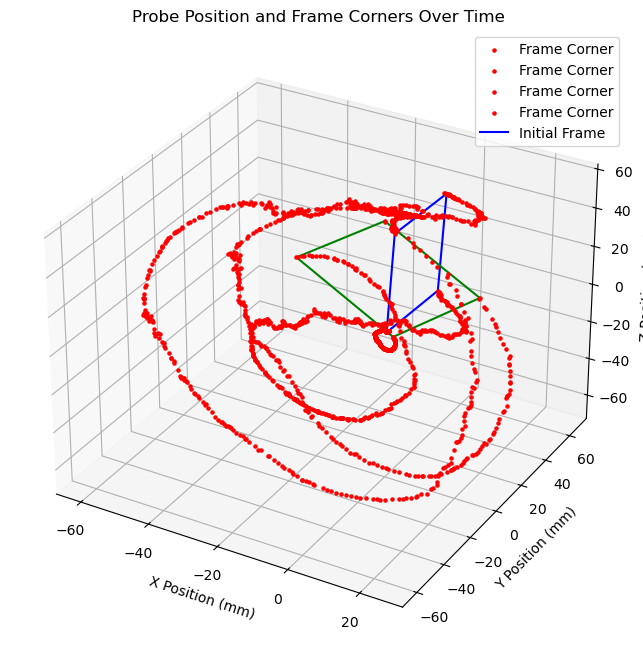

[09/06/24 12:18:10] INFO     INFO:rich:Predicted volume shape: (866, 1264, 1184)                   ]8;id=782758;file:///tmp/ipykernel_1816552/2833458504.py\2833458504.py]8;;\:]8;id=197757;file:///tmp/ipykernel_1816552/2833458504.py#13\13]8;;\

                    INFO     INFO:rich:Volume origin: [-61.02815133 -61.12541301 -64.31500973]     ]8;id=105517;file:///tmp/ipykernel_1816552/2833458504.py\2833458504.py]8;;\:]8;id=66438;file:///tmp/ipykernel_1816552/2833458504.py#14\14]8;;\

                    INFO     INFO:rich:Voxel size: 0.1 mm                                          ]8;id=824841;file:///tmp/ipykernel_1816552/2833458504.py\2833458504.py]8;;\:]8;id=739070;file:///tmp/ipykernel_1816552/2833458504.py#15\15]8;;\

[09/06/24 12:18:16] INFO     INFO:rich:Predicted volume saved as 'predicted_volume.npy'            ]8;id=999252;file:///tmp/ipykernel_1816552/2833458504.py\2833458504.py]8;;\:]8;id=469512;file:///tmp/ipykernel_1816552/2833458504.py#19\19]8;;\

                    INFO     INFO:rich:Metadata saved as 'predicted_volume_metadata.npy'           ]8;id=215328;file:///tmp/ipykernel_1816552/2833458504.py\2833458504.py]8;;\:]8;id=88904;file:///tmp/ipykernel_1816552/2833458504.py#27\27]8;;\

In [76]:
# Perform predicted volume reconstruction using the truncated data
predicted_volume, volume_origin, voxel_size = reconstruct_predicted_volume_displacement(
    truncated_frames[:, 0],  # Use the truncated frames
    truncated_predictions,  # Use the truncated predictions
    PROBE_SPECS,
    voxel_size=0.1,
    scaling_factor_translation=0.1,
    scaling_factor_rotation=10,
    initial_pose=None,
    ignore_orientation=False,
)

logger.info(f"Predicted volume shape: {predicted_volume.shape}")
logger.info(f"Volume origin: {volume_origin}")
logger.info(f"Voxel size: {voxel_size} mm")

# Save the predicted volume and metadata
np.save("predicted_volume.npy", predicted_volume)
logger.info("Predicted volume saved as 'predicted_volume.npy'")

metadata = {
    "volume_origin": volume_origin.tolist(),
    "voxel_size": voxel_size,
    "probe_specs": PROBE_SPECS,
}
np.save("predicted_volume_metadata.npy", metadata)
logger.info("Metadata saved as 'predicted_volume_metadata.npy'")

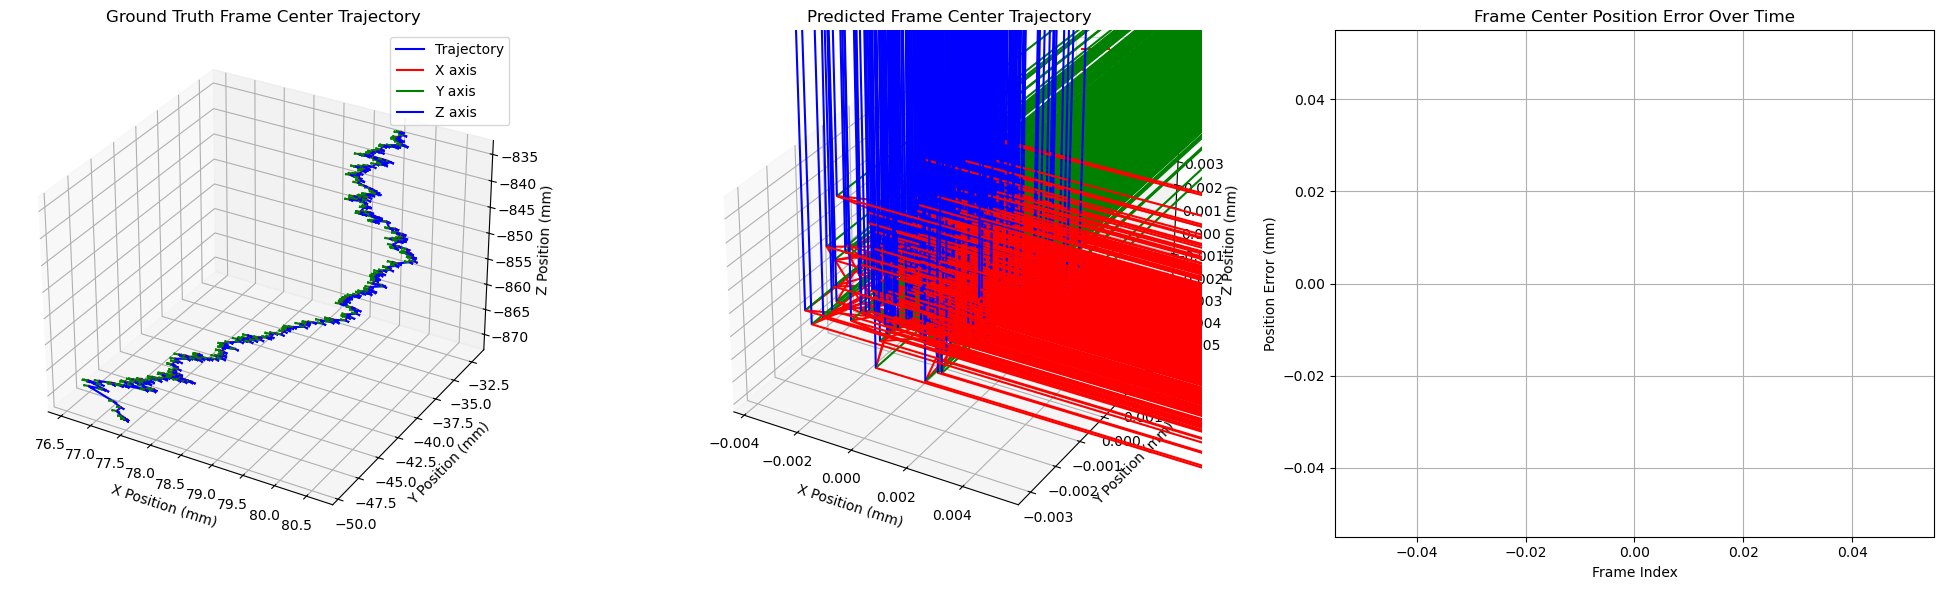

In [77]:
# Plotting final frame center trajectories using truncated predictions
plot_frame_center_trajectories_with_error(
    gt_centers,
    gt_orientations,
    truncated_predictions[:, :3],  # Predicted centers (truncated)
    truncated_predictions[:, 3:],  # Predicted orientations (truncated)
    frame_stride=1,
    scale=0.1,
)